# IMPORTS

In [ ]:
import pandas as pd
import os

import numpy as np

import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import geoplot as gplt
import geoplot.crs as gcrs

from descartes import PolygonPatch
import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

sns.set_context('talk')

idx=pd.IndexSlice

from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 60%; }
</style>
"""))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# SETTINGS

In [ ]:
workdir=os.getcwd()+os.sep
workdir

In [ ]:
datadir=os.path.join(workdir,"data")+os.sep
datadir

# DATA LOADING

## DEPENDENDT VARIABLES

In [ ]:
dep_data=os.path.join(datadir,"dependant v")+os.sep
dep_data

In [ ]:
dep_var_files=[os.path.join(path, name) for path, subdirs, files in os.walk(dep_data) for name in files if name[-3:]=="csv"]
dep_var_files

In [181]:
dep_vars=pd.DataFrame()
for file in dep_var_files:
    tmp=pd.read_csv(file).loc[:,["DATAFLOW","TIME_PERIOD","geo", "OBS_VALUE", "unit"]].rename(columns={"DATAFLOW":"varID"})
    tmp.loc[:,"varDESC"]=file.split("\\")[-1][:-4]
    tmp.loc[:,"COUNTRY"]=tmp.loc[:,"geo"].str[:2]
    tmp.loc[:,"varID"]= tmp.loc[:,"varID"].str.split(":").str[1].str.split("(").str[0]
    tmp.set_index(["varDESC", "TIME_PERIOD", "geo"], inplace=True)
    dep_vars=pd.concat([dep_vars, tmp], axis=0)
dep_vars

varID  OBS_VALUE    unit COUNTRY
varDESC        TIME_PERIOD geo                                      
household.bb   2010        AT11  TGS00048       63.0   PC_HH      AT
               2011        AT11  TGS00048       67.0   PC_HH      AT
               2012        AT11  TGS00048       73.0   PC_HH      AT
               2013        AT11  TGS00048       78.0   PC_HH      AT
               2014        AT11  TGS00048       80.0   PC_HH      AT
...                                   ...        ...     ...     ...
uni.or.hi-tech 2015        UKN0  TGS00038       46.1  PC_ACT      UK
               2016        UKN0  TGS00038       45.6  PC_ACT      UK
               2017        UKN0  TGS00038       48.1  PC_ACT      UK
               2018        UKN0  TGS00038       48.6  PC_ACT      UK
               2019        UKN0  TGS00038       51.0  PC_ACT      UK

[19640 rows x 4 columns]

In [182]:
dep_vars.index.is_unique

True

In [183]:
dep_vars=dep_vars.reset_index()
dep_vars=dep_vars[dep_vars.loc[:,"geo"].str.len()==4]
dep_vars=dep_vars[dep_vars.loc[:,"geo"]!="EU28"]

In [184]:
geo_codes_to_keep=[g for g in list(dep_vars.loc[:,"geo"].unique()) if g[:3] not in ["PT2", "PT3", "ES7", "FRY"]]
geo_codes_to_keep

['AT11',
 'AT12',
 'AT13',
 'AT21',
 'AT22',
 'AT31',
 'AT32',
 'AT33',
 'AT34',
 'BE10',
 'BE21',
 'BE22',
 'BE23',
 'BE24',
 'BE25',
 'BE31',
 'BE32',
 'BE33',
 'BE34',
 'BE35',
 'BG31',
 'BG32',
 'BG33',
 'BG34',
 'BG41',
 'BG42',
 'CH01',
 'CH02',
 'CH03',
 'CH04',
 'CH05',
 'CH06',
 'CH07',
 'CY00',
 'CZ01',
 'CZ02',
 'CZ03',
 'CZ04',
 'CZ05',
 'CZ06',
 'CZ07',
 'CZ08',
 'DK01',
 'DK02',
 'DK03',
 'DK04',
 'DK05',
 'EE00',
 'ES11',
 'ES12',
 'ES13',
 'ES21',
 'ES22',
 'ES23',
 'ES24',
 'ES30',
 'ES41',
 'ES42',
 'ES43',
 'ES51',
 'ES52',
 'ES53',
 'ES61',
 'ES62',
 'ES63',
 'ES64',
 'FI19',
 'FI1B',
 'FI1C',
 'FI1D',
 'FR10',
 'FRB0',
 'FRC1',
 'FRC2',
 'FRD1',
 'FRD2',
 'FRE1',
 'FRE2',
 'FRF1',
 'FRF2',
 'FRF3',
 'FRG0',
 'FRH0',
 'FRI1',
 'FRI2',
 'FRI3',
 'FRJ1',
 'FRJ2',
 'FRK1',
 'FRK2',
 'FRL0',
 'FRM0',
 'HR03',
 'HR04',
 'HU10',
 'HU11',
 'HU12',
 'HU21',
 'HU22',
 'HU23',
 'HU31',
 'HU32',
 'HU33',
 'IE01',
 'IE02',
 'IE04',
 'IE05',
 'IE06',
 'IS00',
 'ITC1',
 'ITC2',
 

In [185]:
dep_vars=dep_vars.loc[dep_vars.loc[:,"geo"].isin(geo_codes_to_keep)]
dep_vars

,varDESC,TIME_PERIOD,geo,varID,OBS_VALUE,unit,COUNTRY
0,household.bb,2010,AT11,TGS00048,63.0,PC_HH,AT
1,household.bb,2011,AT11,TGS00048,67.0,PC_HH,AT
2,household.bb,2012,AT11,TGS00048,73.0,PC_HH,AT
3,household.bb,2013,AT11,TGS00048,78.0,PC_HH,AT
4,household.bb,2014,AT11,TGS00048,80.0,PC_HH,AT
...,...,...,...,...,...,...,...
19635,uni.or.hi-tech,2015,UKN0,TGS00038,46.1,PC_ACT,UK
19636,uni.or.hi-tech,2016,UKN0,TGS00038,45.6,PC_ACT,UK
19637,uni.or.hi-tech,2017,UKN0,TGS00038,48.1,PC_ACT,UK
19638,uni.or.hi-tech,2018,UKN0,TGS00038,48.6,PC_ACT,UK


In [186]:
dep_vars["geo"].str[0:2].unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DK', 'EE', 'ES', 'FI', 'FR',
       'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MK', 'MT', 'NL',
       'NO', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'PL', 'DE', 'EL', 'ME',
       'UK', 'TR'], dtype=object)

In [187]:
len(dep_vars["geo"].str[0:2].unique())

35

In [188]:
len(dep_vars["geo"].unique())

361

In [189]:
dep_vars.set_index(["varDESC", "TIME_PERIOD", "geo"], inplace=True)

In [190]:
dep_vars.groupby(level=[0,1]).size().unstack(1).fillna(0)

TIME_PERIOD,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
varDESC,,,,,,,,,,,,,,,,
"gdp,r&d",0.0,0.0,0.0,259.0,190.0,278.0,205.0,280.0,184.0,261.0,191.0,258.0,203.0,214.0,5.0,0.0
hi-tech.emloy,0.0,0.0,0.0,305.0,308.0,310.0,310.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,279.0,0.0
household.bb,0.0,0.0,0.0,0.0,140.0,139.0,144.0,144.0,175.0,159.0,168.0,176.0,172.0,183.0,154.0,156.0
household.internet,0.0,0.0,0.0,0.0,140.0,139.0,144.0,144.0,175.0,159.0,168.0,176.0,172.0,183.0,154.0,156.0
ind.freq.use.,0.0,0.0,0.0,0.0,140.0,139.0,144.0,144.0,175.0,159.0,168.0,176.0,172.0,183.0,154.0,156.0
ind.never.used,69.0,85.0,128.0,125.0,140.0,139.0,144.0,144.0,168.0,159.0,0.0,169.0,0.0,0.0,0.0,0.0
ind.ordered.online,0.0,0.0,0.0,0.0,140.0,139.0,144.0,144.0,175.0,159.0,168.0,176.0,172.0,183.0,154.0,156.0
uni.or.hi-tech,0.0,0.0,0.0,306.0,309.0,310.0,311.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,279.0,0.0


In [191]:
dep_vars.index.get_level_values(0).unique()

Index(['household.bb', 'household.internet', 'ind.freq.use.', 'ind.never.used',
       'ind.ordered.online', 'gdp,r&d', 'hi-tech.emloy', 'uni.or.hi-tech'],
      dtype='object', name='varDESC')

## INDEPENDENDT VARIABLES

In [ ]:
indep_data=os.path.join(datadir,"independant v")+os.sep
indep_data

In [ ]:
indep_var_files=[os.path.join(path, name) for path, subdirs, files in os.walk(indep_data) for name in files if name[-3:]=="csv"]
indep_var_files

In [194]:
indep_vars=pd.DataFrame()

for file in indep_var_files:
    
    tmp=pd.read_csv(file)
    
    #at-risk-pov
    if file.split("\\")[-1][:-4]=="at-risk-pov":
        tmp=tmp.where(tmp["unit"]=="PC").dropna() #pc=percentage
        
    #highschool
    if file.split("\\")[-1][:-4]=="highschool":
        tmp=tmp.where(tmp["age"]=="Y15-24").dropna() #there are other options
        
    #ow-work-intensity
    if file.split("\\")[-1][:-4]=="low-work-intensity":
        tmp=tmp.where(tmp["unit"]=="PC_Y_LT60").dropna() #there are other options

    #median.age
    if file.split("\\")[-1][:-4]=="median.age":
        tmp=tmp.where(tmp["indic_de"]=="MEDAGEPOP").dropna() #there are other options        
        
    #pov-soc-exclusion
    if file.split("\\")[-1][:-4]=="pov-soc-exclusion":
        tmp=tmp.where(tmp["unit"]=="PC").dropna() #there are other options

    #uni
    if file.split("\\")[-1][:-4]=="uni":
        tmp=tmp.where(tmp["sex"]=="T").dropna()
                
    #unemp
    if file.split("\\")[-1][:-4]=="unemp":
        tmp=tmp.where(tmp["sex"]=="T").dropna()
        tmp=tmp.where(tmp["isced11"]=="TOTAL").dropna()
        
    #LT-unemp
    if file.split("\\")[-1][:-4]=="LT-unemp":
        tmp=tmp.where(tmp["sex"]=="T").dropna()
        tmp=tmp.where(tmp["isced11"]=="TOTAL").dropna()
        tmp=tmp.where(tmp["age"]=="Y15-74").dropna()
    
    tmp=tmp.loc[:,["DATAFLOW","TIME_PERIOD","geo", "OBS_VALUE", "unit"]].rename(columns={"DATAFLOW":"varID"})
    tmp.loc[:,"varDESC"]=file.split("\\")[-1][:-4]
    tmp.loc[:,"COUNTRY"]=tmp.loc[:,"geo"].str[:2]
    tmp.loc[:,"varID"]= tmp.loc[:,"varID"].str.split(":").str[1].str.split("(").str[0]
    tmp.set_index(["varDESC", "TIME_PERIOD", "geo"], inplace=True)
    indep_vars=pd.concat([indep_vars, tmp], axis=0)
    
indep_vars

varID  OBS_VALUE unit COUNTRY
varDESC     TIME_PERIOD geo                                   
at-risk-pov 2014.0      AT11  ILC_LI41        9.1   PC      AT
            2015.0      AT11  ILC_LI41       11.7   PC      AT
            2016.0      AT11  ILC_LI41       12.7   PC      AT
            2017.0      AT11  ILC_LI41       13.1   PC      AT
            2018.0      AT11  ILC_LI41       11.8   PC      AT
...                                ...        ...  ...     ...
uni         2014.0      UKM8  TGS00109       45.4   PC      UK
                        UKM9  TGS00109       40.5   PC      UK
            2010.0      UKN0  TGS00109       31.5   PC      UK
            2011.0      UKN0  TGS00109       29.1   PC      UK
            2014.0      UKN0  TGS00109       34.0   PC      UK

[22557 rows x 4 columns]

In [195]:
indep_vars.index.is_unique

True

In [196]:
indep_vars

varID  OBS_VALUE unit COUNTRY
varDESC     TIME_PERIOD geo                                   
at-risk-pov 2014.0      AT11  ILC_LI41        9.1   PC      AT
            2015.0      AT11  ILC_LI41       11.7   PC      AT
            2016.0      AT11  ILC_LI41       12.7   PC      AT
            2017.0      AT11  ILC_LI41       13.1   PC      AT
            2018.0      AT11  ILC_LI41       11.8   PC      AT
...                                ...        ...  ...     ...
uni         2014.0      UKM8  TGS00109       45.4   PC      UK
                        UKM9  TGS00109       40.5   PC      UK
            2010.0      UKN0  TGS00109       31.5   PC      UK
            2011.0      UKN0  TGS00109       29.1   PC      UK
            2014.0      UKN0  TGS00109       34.0   PC      UK

[22557 rows x 4 columns]

In [197]:
indep_vars.reset_index().loc[:,"geo"].unique()

array(['AT11', 'AT12', 'AT13', ..., 'UKN16', 'UKM2', 'UKM3'], dtype=object)

In [198]:
indep_vars=indep_vars.reset_index()
indep_vars=indep_vars[indep_vars.loc[:,"geo"].str.len()==4]
indep_vars=indep_vars[indep_vars.loc[:,"geo"]!="EU28"]

In [199]:
geo_codes_to_keep=[g for g in list(indep_vars.loc[:,"geo"].unique()) if g[:3] not in ["PT2", "PT3", "ES7", "FRY"]]
geo_codes_to_keep

['AT11',
 'AT12',
 'AT13',
 'AT21',
 'AT22',
 'AT31',
 'AT32',
 'AT33',
 'AT34',
 'BG31',
 'BG32',
 'BG33',
 'BG34',
 'BG41',
 'BG42',
 'CH01',
 'CH02',
 'CH03',
 'CH04',
 'CH05',
 'CH06',
 'CH07',
 'DK01',
 'DK02',
 'DK03',
 'DK04',
 'DK05',
 'ES11',
 'ES12',
 'ES13',
 'ES21',
 'ES22',
 'ES23',
 'ES24',
 'ES30',
 'ES41',
 'ES42',
 'ES43',
 'ES51',
 'ES52',
 'ES53',
 'ES61',
 'ES62',
 'ES63',
 'ES64',
 'IE04',
 'IE05',
 'IE06',
 'NL11',
 'NL12',
 'NL13',
 'NL21',
 'NL22',
 'NL23',
 'NL31',
 'NL32',
 'NL33',
 'NL34',
 'NL41',
 'NL42',
 'PL21',
 'PL22',
 'PL41',
 'PL42',
 'PL43',
 'PL51',
 'PL52',
 'PL61',
 'PL62',
 'PL63',
 'PL71',
 'PL72',
 'PL81',
 'PL82',
 'PL84',
 'PL91',
 'PL92',
 'SE11',
 'SE12',
 'SE21',
 'SE22',
 'SE23',
 'SE31',
 'SE32',
 'SE33',
 'AL01',
 'AL02',
 'AL03',
 'ATZZ',
 'BE10',
 'BE21',
 'BE22',
 'BE23',
 'BE24',
 'BE25',
 'BE31',
 'BE32',
 'BE33',
 'BE34',
 'BE35',
 'BEZZ',
 'CY00',
 'CZ01',
 'CZ02',
 'CZ03',
 'CZ04',
 'CZ05',
 'CZ06',
 'CZ07',
 'CZ08',
 'DE11',
 

In [200]:
indep_vars=indep_vars.loc[indep_vars.loc[:,"geo"].isin(geo_codes_to_keep)]
indep_vars

,varDESC,TIME_PERIOD,geo,varID,OBS_VALUE,unit,COUNTRY
0,at-risk-pov,2014.0,AT11,ILC_LI41,9.1,PC,AT
1,at-risk-pov,2015.0,AT11,ILC_LI41,11.7,PC,AT
2,at-risk-pov,2016.0,AT11,ILC_LI41,12.7,PC,AT
3,at-risk-pov,2017.0,AT11,ILC_LI41,13.1,PC,AT
4,at-risk-pov,2018.0,AT11,ILC_LI41,11.8,PC,AT
...,...,...,...,...,...,...,...
22552,uni,2014.0,UKM8,TGS00109,45.4,PC,UK
22553,uni,2014.0,UKM9,TGS00109,40.5,PC,UK
22554,uni,2010.0,UKN0,TGS00109,31.5,PC,UK
22555,uni,2011.0,UKN0,TGS00109,29.1,PC,UK


In [201]:
pd.Series(indep_vars.loc[:,"geo"].sort_values().unique()).str[0:2].unique()

array(['AL', 'AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EF',
       'EL', 'ES', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI', 'LT',
       'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS',
       'SE', 'SI', 'SK', 'TR', 'UK'], dtype=object)

In [202]:
len(pd.Series(indep_vars.loc[:,"geo"].sort_values().unique()).str[0:2].unique())

38

In [203]:
len(pd.Series(indep_vars.loc[:,"geo"].unique()).unique())

343

https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Country_codes

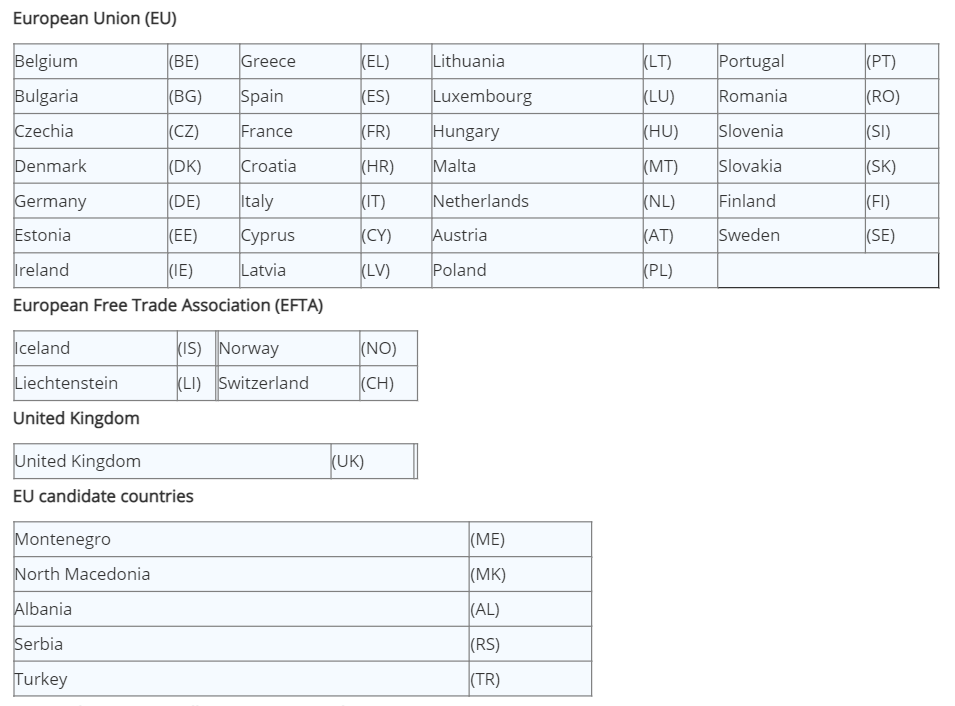

In [204]:
indep_vars.set_index(["varDESC", "TIME_PERIOD", "geo"], inplace=True)

In [205]:
indep_vars.groupby(level=[0,1]).size().unstack(1).fillna(0)

TIME_PERIOD,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
varDESC,,,,,,,,,,,,,
GDP,0.0,0.0,262.0,262.0,267.0,267.0,267.0,290.0,290.0,290.0,290.0,282.0,0.0
LT-unemp,0.0,48.0,91.0,89.0,58.0,19.0,45.0,20.0,44.0,57.0,48.0,55.0,39.0
at-risk-pov,26.0,0.0,0.0,5.0,0.0,0.0,16.0,9.0,27.0,9.0,9.0,0.0,25.0
highschool,0.0,0.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,12.0,26.0,0.0
household.income,0.0,0.0,238.0,238.0,245.0,245.0,245.0,244.0,244.0,244.0,244.0,42.0,0.0
low-work-intensity,8.0,0.0,0.0,0.0,0.0,0.0,16.0,9.0,27.0,9.0,9.0,0.0,20.0
median.age,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,43.0,0.0
populationn.densitty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,321.0,321.0,325.0,325.0,284.0,0.0
pov-soc-exclusion,26.0,0.0,0.0,5.0,0.0,0.0,22.0,9.0,64.0,46.0,47.0,36.0,25.0


## DEPENDENT AND INDEPENDET VARIABLES MERGING

In [206]:
dep_vars["OBS_VALUE"].unstack(0)

varDESC           gdp,r&d  hi-tech.emloy  household.bb  household.internet  \
TIME_PERIOD geo                                                              
2006        AT11      NaN            NaN           NaN                 NaN   
            AT12      NaN            NaN           NaN                 NaN   
            AT13      NaN            NaN           NaN                 NaN   
            AT21      NaN            NaN           NaN                 NaN   
            AT22      NaN            NaN           NaN                 NaN   
...                   ...            ...           ...                 ...   
2021        SI04      NaN            NaN          95.0                95.0   
            SK01      NaN            NaN          96.0                96.0   
            SK02      NaN            NaN          89.0                89.0   
            SK03      NaN            NaN          91.0                91.0   
            SK04      NaN            NaN          87.0                87.0   

varDESC           ind.freq.use.  ind.never.used  ind.ordered.online  \
TIME_PERIOD geo                                                       
2006        AT11            NaN            30.0                 NaN   
            AT12            NaN            25.0                 NaN   
            AT13            NaN            19.0                 NaN   
            AT21            NaN            29.0                 NaN   
            AT22            NaN            26.0                 NaN   
...                         ...             ...                 ...   
2021        SI04           92.0             NaN                74.0   
            SK01           94.0             NaN                82.0   
            SK02           87.0             NaN                75.0   
            SK03           87.0             NaN                75.0   
            SK04           85.0             NaN                73.0   

varDESC           uni.or.hi-tech  
TIME_PERIOD geo                   
2006        AT11             NaN  
            AT12             NaN  
            AT13             NaN  
            AT21             NaN  
            AT22             NaN  
...                          ...  
2021        SI04             NaN  
            SK01             NaN  
            SK02             NaN  
            SK03             NaN  
            SK04             NaN  

[4389 rows x 8 columns]

In [207]:
indep_vars["OBS_VALUE"].unstack(0)

varDESC           GDP  LT-unemp  at-risk-pov  highschool  household.income  \
TIME_PERIOD geo                                                              
2008.0      ES11  NaN       NaN         20.9         NaN               NaN   
            ES12  NaN       NaN         13.2         NaN               NaN   
            ES13  NaN       NaN         14.3         NaN               NaN   
            ES21  NaN       NaN          9.1         NaN               NaN   
            ES22  NaN       NaN          5.9         NaN               NaN   
...               ...       ...          ...         ...               ...   
2020.0      TRB1  NaN       NaN          NaN         NaN               NaN   
            TRB2  NaN       NaN          NaN         NaN               NaN   
            TRC1  NaN       NaN          NaN         NaN               NaN   
            TRC2  NaN       NaN          NaN         NaN               NaN   
            TRC3  NaN       NaN          NaN         NaN               NaN   

varDESC           low-work-intensity  median.age  populationn.densitty  \
TIME_PERIOD geo                                                          
2008.0      ES11                 NaN         NaN                   NaN   
            ES12                 NaN         NaN                   NaN   
            ES13                 NaN         NaN                   NaN   
            ES21                 NaN         NaN                   NaN   
            ES22                 NaN         NaN                   NaN   
...                              ...         ...                   ...   
2020.0      TRB1                 NaN         NaN                   NaN   
            TRB2                 NaN         NaN                   NaN   
            TRC1                 NaN         NaN                   NaN   
            TRC2                 NaN         NaN                   NaN   
            TRC3                 NaN         NaN                   NaN   

varDESC           pov-soc-exclusion  senior_pop  unemp  uni  
TIME_PERIOD geo                                              
2008.0      ES11               25.1         NaN    NaN  NaN  
            ES12               19.5         NaN    NaN  NaN  
            ES13               19.9         NaN    NaN  NaN  
            ES21               13.9         NaN    NaN  NaN  
            ES22                8.6         NaN    NaN  NaN  
...                             ...         ...    ...  ...  
2020.0      TRB1                NaN         9.8    NaN  NaN  
            TRB2                NaN         4.3    NaN  NaN  
            TRC1                NaN         6.1    NaN  NaN  
            TRC2                NaN         4.4    NaN  NaN  
            TRC3                NaN         4.7    NaN  NaN  

[3657 rows x 12 columns]

In [208]:
dataset=pd.merge(dep_vars["OBS_VALUE"].unstack(0), indep_vars["OBS_VALUE"].unstack(0), how="inner", left_index=True, right_index=True)
dataset

varDESC           gdp,r&d  hi-tech.emloy  household.bb  household.internet  \
TIME_PERIOD geo                                                              
2008        ES11      NaN            NaN           NaN                 NaN   
            ES12      NaN            NaN           NaN                 NaN   
            ES13      NaN            NaN           NaN                 NaN   
            ES21      NaN            NaN           NaN                 NaN   
            ES22      NaN            NaN           NaN                 NaN   
...                   ...            ...           ...                 ...   
2020        TRB1      NaN            0.3           NaN                 NaN   
            TRB2      NaN            0.1           NaN                 NaN   
            TRC1      NaN            0.5           NaN                 NaN   
            TRC2      NaN            0.6           NaN                 NaN   
            TRC3      NaN            0.3           NaN                 NaN   

varDESC           ind.freq.use.  ind.never.used  ind.ordered.online  \
TIME_PERIOD geo                                                       
2008        ES11            NaN            42.0                 NaN   
            ES12            NaN            34.0                 NaN   
            ES13            NaN            32.0                 NaN   
            ES21            NaN            30.0                 NaN   
            ES22            NaN            29.0                 NaN   
...                         ...             ...                 ...   
2020        TRB1            NaN             NaN                 NaN   
            TRB2            NaN             NaN                 NaN   
            TRC1            NaN             NaN                 NaN   
            TRC2            NaN             NaN                 NaN   
            TRC3            NaN             NaN                 NaN   

varDESC           uni.or.hi-tech  GDP  LT-unemp  at-risk-pov  highschool  \
TIME_PERIOD geo                                                            
2008        ES11             NaN  NaN       NaN         20.9         NaN   
            ES12             NaN  NaN       NaN         13.2         NaN   
            ES13             NaN  NaN       NaN         14.3         NaN   
            ES21             NaN  NaN       NaN          9.1         NaN   
            ES22             NaN  NaN       NaN          5.9         NaN   
...                          ...  ...       ...          ...         ...   
2020        TRB1            30.6  NaN       NaN          NaN         NaN   
            TRB2            19.8  NaN       NaN          NaN         NaN   
            TRC1            25.4  NaN       NaN          NaN         NaN   
            TRC2            19.1  NaN       NaN          NaN         NaN   
            TRC3            22.7  NaN       NaN          NaN         NaN   

varDESC           household.income  low-work-intensity  median.age  \
TIME_PERIOD geo                                                      
2008        ES11               NaN                 NaN         NaN   
            ES12               NaN                 NaN         NaN   
            ES13               NaN                 NaN         NaN   
            ES21               NaN                 NaN         NaN   
            ES22               NaN                 NaN         NaN   
...                            ...                 ...         ...   
2020        TRB1               NaN                 NaN         NaN   
            TRB2               NaN                 NaN         NaN   
            TRC1               NaN                 NaN         NaN   
            TRC2               NaN                 NaN         NaN   
            TRC3               NaN                 NaN         NaN   

varDESC           populationn.densitty  pov-soc-exclusion  senior_pop  unemp  \
TIME_PERIOD geo                                                                
2

In [209]:
dataset.index.get_level_values(1).nunique()

326

In [210]:
dataset.index.get_level_values(0).unique()

Int64Index([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
            2019, 2020],
           dtype='int64', name='TIME_PERIOD')

In [211]:
dataset.index.get_level_values(0).nunique()

13

In [212]:
dataset.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
varDESC,,,,,,,,
"gdp,r&d",1958.0,1.51,1.85,0.00,0.63,1.16,1.80,39.17
hi-tech.emloy,3191.0,3.44,2.09,0.10,2.00,3.10,4.50,12.90
household.bb,1712.0,77.25,14.32,15.00,70.00,80.00,87.00,100.00
household.internet,1720.0,80.50,13.28,26.00,73.00,83.00,91.00,100.00
ind.freq.use.,1720.0,76.33,14.87,28.00,67.00,79.00,88.00,100.00
ind.never.used,1067.0,19.60,13.56,0.00,8.00,17.00,30.00,58.00
ind.ordered.online,1720.0,48.60,22.34,1.00,31.00,51.00,68.00,91.00
uni.or.hi-tech,3401.0,40.31,11.37,9.60,32.30,41.60,47.70,81.80
GDP,2566.0,46844.79,58041.62,124.57,14209.86,28260.60,57751.25,742569.25


### DATA TRANSFORMATION AND MANIPULATION

Variables creation

In [213]:
dataset["GDP"]=dataset["GDP"]/1000
dataset["household.income"]=dataset["household.income"]/1000

In [214]:
dataset.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
varDESC,,,,,,,,
"gdp,r&d",1958.0,1.51,1.85,0.00,0.63,1.16,1.80,39.17
hi-tech.emloy,3191.0,3.44,2.09,0.10,2.00,3.10,4.50,12.90
household.bb,1712.0,77.25,14.32,15.00,70.00,80.00,87.00,100.00
household.internet,1720.0,80.50,13.28,26.00,73.00,83.00,91.00,100.00
ind.freq.use.,1720.0,76.33,14.87,28.00,67.00,79.00,88.00,100.00
ind.never.used,1067.0,19.60,13.56,0.00,8.00,17.00,30.00,58.00
ind.ordered.online,1720.0,48.60,22.34,1.00,31.00,51.00,68.00,91.00
uni.or.hi-tech,3401.0,40.31,11.37,9.60,32.30,41.60,47.70,81.80
GDP,2566.0,46.84,58.04,0.12,14.21,28.26,57.75,742.57


In [215]:
dataset=dataset.reset_index()
dataset["TIME_PERIOD"]=dataset["TIME_PERIOD"].astype(int)
dataset

varDESC,TIME_PERIOD,geo,"gdp,r&d",hi-tech.emloy,household.bb,household.internet,ind.freq.use.,ind.never.used,ind.ordered.online,uni.or.hi-tech,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni
0,2008,ES11,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,20.9,NaN,NaN,NaN,NaN,NaN,25.1,NaN,NaN,NaN
1,2008,ES12,NaN,NaN,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,13.2,NaN,NaN,NaN,NaN,NaN,19.5,NaN,NaN,NaN
2,2008,ES13,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,14.3,NaN,NaN,NaN,NaN,NaN,19.9,NaN,NaN,NaN
3,2008,ES21,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,9.1,NaN,NaN,NaN,NaN,NaN,13.9,NaN,NaN,NaN
4,2008,ES22,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,5.9,NaN,NaN,NaN,NaN,NaN,8.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428,2020,TRB1,NaN,0.3,NaN,NaN,NaN,NaN,NaN,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.8,NaN,NaN
3429,2020,TRB2,NaN,0.1,NaN,NaN,NaN,NaN,NaN,19.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3,NaN,NaN
3430,2020,TRC1,NaN,0.5,NaN,NaN,NaN,NaN,NaN,25.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,NaN,NaN
3431,2020,TRC2,NaN,0.6,NaN,NaN,NaN,NaN,NaN,19.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4,NaN,NaN


In [216]:
dataset=dataset.set_index(["TIME_PERIOD","geo"])

In [217]:
dataset.loc[:,"median.age"]=dataset.groupby(level=1)["median.age"].fillna(method="ffill").fillna(method="bfill")

In [218]:
dataset.loc[:,"senior_pop"]=dataset.groupby(level=1)["senior_pop"].fillna(method="ffill").fillna(method="bfill")

In [219]:
(dataset.count()/dataset.shape[0]).mean()

0.4618118263909117

In [220]:
dataset.count()/dataset.shape[0] # % of available data for each variables

varDESC
gdp,r&d                 0.570347
hi-tech.emloy           0.929508
household.bb            0.498689
household.internet      0.501020
ind.freq.use.           0.501020
ind.never.used          0.310807
ind.ordered.online      0.501020
uni.or.hi-tech          0.990679
GDP                     0.747451
LT-unemp                0.178561
at-risk-pov             0.034372
highschool              0.015438
household.income        0.628313
low-work-intensity      0.026216
median.age              0.970871
populationn.densitty    0.451791
pov-soc-exclusion       0.079231
senior_pop              1.000000
unemp                   0.104282
uni                     0.196621
dtype: float64

In [221]:
a=dataset.count()/dataset.shape[0] # if you filter variable with less tahn 20%  of obs, then the availael data are 63%
a[a>0.20].mean()

0.6616549777050797

In [222]:
dataset.min()

varDESC
gdp,r&d                  0.00000
hi-tech.emloy            0.10000
household.bb            15.00000
household.internet      26.00000
ind.freq.use.           28.00000
ind.never.used           0.00000
ind.ordered.online       1.00000
uni.or.hi-tech           9.60000
GDP                      0.12457
LT-unemp                 0.30000
at-risk-pov              5.90000
highschool              19.00000
household.income         0.00000
low-work-intensity       2.30000
median.age              37.20000
populationn.densitty     3.30000
pov-soc-exclusion        8.60000
senior_pop               3.80000
unemp                    1.90000
uni                      7.00000
dtype: float64

In [223]:
dataset.max()

varDESC
gdp,r&d                    39.17000
hi-tech.emloy              12.90000
household.bb              100.00000
household.internet        100.00000
ind.freq.use.             100.00000
ind.never.used             58.00000
ind.ordered.online         91.00000
uni.or.hi-tech             81.80000
GDP                       742.56925
LT-unemp                   15.30000
at-risk-pov                40.10000
highschool                100.00000
household.income          395.31540
low-work-intensity         19.40000
median.age                 51.00000
populationn.densitty    11509.10000
pov-soc-exclusion          46.90000
senior_pop                 29.30000
unemp                      24.00000
uni                        69.60000
dtype: float64

In [224]:
dataset

varDESC           gdp,r&d  hi-tech.emloy  household.bb  household.internet  \
TIME_PERIOD geo                                                              
2008        ES11      NaN            NaN           NaN                 NaN   
            ES12      NaN            NaN           NaN                 NaN   
            ES13      NaN            NaN           NaN                 NaN   
            ES21      NaN            NaN           NaN                 NaN   
            ES22      NaN            NaN           NaN                 NaN   
...                   ...            ...           ...                 ...   
2020        TRB1      NaN            0.3           NaN                 NaN   
            TRB2      NaN            0.1           NaN                 NaN   
            TRC1      NaN            0.5           NaN                 NaN   
            TRC2      NaN            0.6           NaN                 NaN   
            TRC3      NaN            0.3           NaN                 NaN   

varDESC           ind.freq.use.  ind.never.used  ind.ordered.online  \
TIME_PERIOD geo                                                       
2008        ES11            NaN            42.0                 NaN   
            ES12            NaN            34.0                 NaN   
            ES13            NaN            32.0                 NaN   
            ES21            NaN            30.0                 NaN   
            ES22            NaN            29.0                 NaN   
...                         ...             ...                 ...   
2020        TRB1            NaN             NaN                 NaN   
            TRB2            NaN             NaN                 NaN   
            TRC1            NaN             NaN                 NaN   
            TRC2            NaN             NaN                 NaN   
            TRC3            NaN             NaN                 NaN   

varDESC           uni.or.hi-tech  GDP  LT-unemp  at-risk-pov  highschool  \
TIME_PERIOD geo                                                            
2008        ES11             NaN  NaN       NaN         20.9         NaN   
            ES12             NaN  NaN       NaN         13.2         NaN   
            ES13             NaN  NaN       NaN         14.3         NaN   
            ES21             NaN  NaN       NaN          9.1         NaN   
            ES22             NaN  NaN       NaN          5.9         NaN   
...                          ...  ...       ...          ...         ...   
2020        TRB1            30.6  NaN       NaN          NaN         NaN   
            TRB2            19.8  NaN       NaN          NaN         NaN   
            TRC1            25.4  NaN       NaN          NaN         NaN   
            TRC2            19.1  NaN       NaN          NaN         NaN   
            TRC3            22.7  NaN       NaN          NaN         NaN   

varDESC           household.income  low-work-intensity  median.age  \
TIME_PERIOD geo                                                      
2008        ES11               NaN                 NaN        37.2   
            ES12               NaN                 NaN        37.2   
            ES13               NaN                 NaN        37.2   
            ES21               NaN                 NaN        37.2   
            ES22               NaN                 NaN        37.2   
...                            ...                 ...         ...   
2020        TRB1               NaN                 NaN         NaN   
            TRB2               NaN                 NaN         NaN   
            TRC1               NaN                 NaN         NaN   
            TRC2               NaN                 NaN         NaN   
            TRC3               NaN                 NaN         NaN   

varDESC           populationn.densitty  pov-soc-exclusion  senior_pop  unemp  \
TIME_PERIOD geo                                                                
2

In [225]:
dep_vars_list=dataset.columns[:8].to_list()
dep_vars_list

['gdp,r&d',
 'hi-tech.emloy',
 'household.bb',
 'household.internet',
 'ind.freq.use.',
 'ind.never.used',
 'ind.ordered.online',
 'uni.or.hi-tech']

In [226]:
indep_vars_list=dataset.columns[8:].to_list()
indep_vars_list

['GDP',
 'LT-unemp',
 'at-risk-pov',
 'highschool',
 'household.income',
 'low-work-intensity',
 'median.age',
 'populationn.densitty',
 'pov-soc-exclusion',
 'senior_pop',
 'unemp',
 'uni']

array([[<AxesSubplot:title={'center':'gdp,r&d'}>,
        <AxesSubplot:title={'center':'hi-tech.emloy'}>,
        <AxesSubplot:title={'center':'household.bb'}>],
       [<AxesSubplot:title={'center':'household.internet'}>,
        <AxesSubplot:title={'center':'ind.freq.use.'}>,
        <AxesSubplot:title={'center':'ind.never.used'}>],
       [<AxesSubplot:title={'center':'ind.ordered.online'}>,
        <AxesSubplot:title={'center':'uni.or.hi-tech'}>, <AxesSubplot:>]],
      dtype=object)

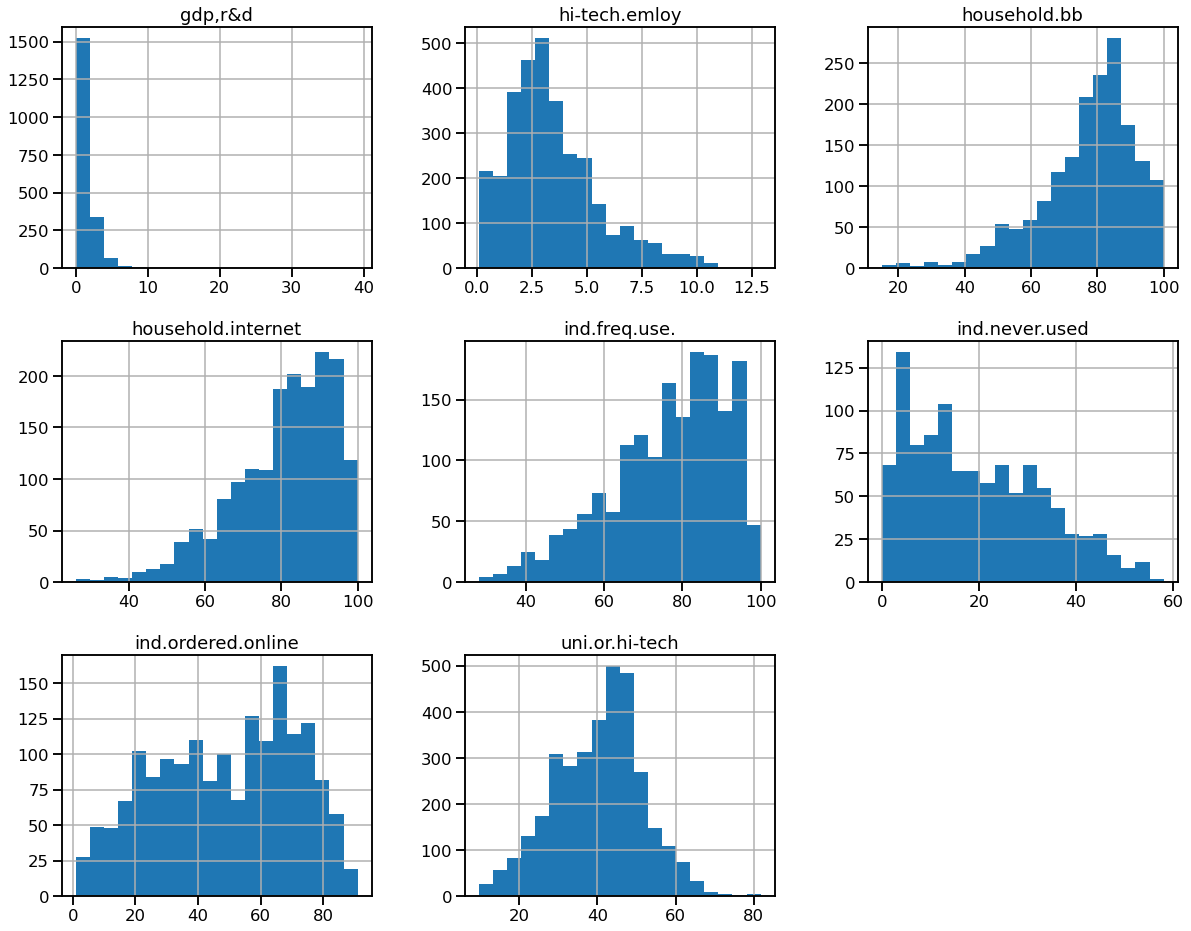

In [227]:
dataset[dep_vars_list].hist(bins=20, figsize=(20,16))

array([[<AxesSubplot:title={'center':'GDP'}>,
        <AxesSubplot:title={'center':'LT-unemp'}>,
        <AxesSubplot:title={'center':'at-risk-pov'}>],
       [<AxesSubplot:title={'center':'highschool'}>,
        <AxesSubplot:title={'center':'household.income'}>,
        <AxesSubplot:title={'center':'low-work-intensity'}>],
       [<AxesSubplot:title={'center':'median.age'}>,
        <AxesSubplot:title={'center':'populationn.densitty'}>,
        <AxesSubplot:title={'center':'pov-soc-exclusion'}>],
       [<AxesSubplot:title={'center':'senior_pop'}>,
        <AxesSubplot:title={'center':'unemp'}>,
        <AxesSubplot:title={'center':'uni'}>]], dtype=object)

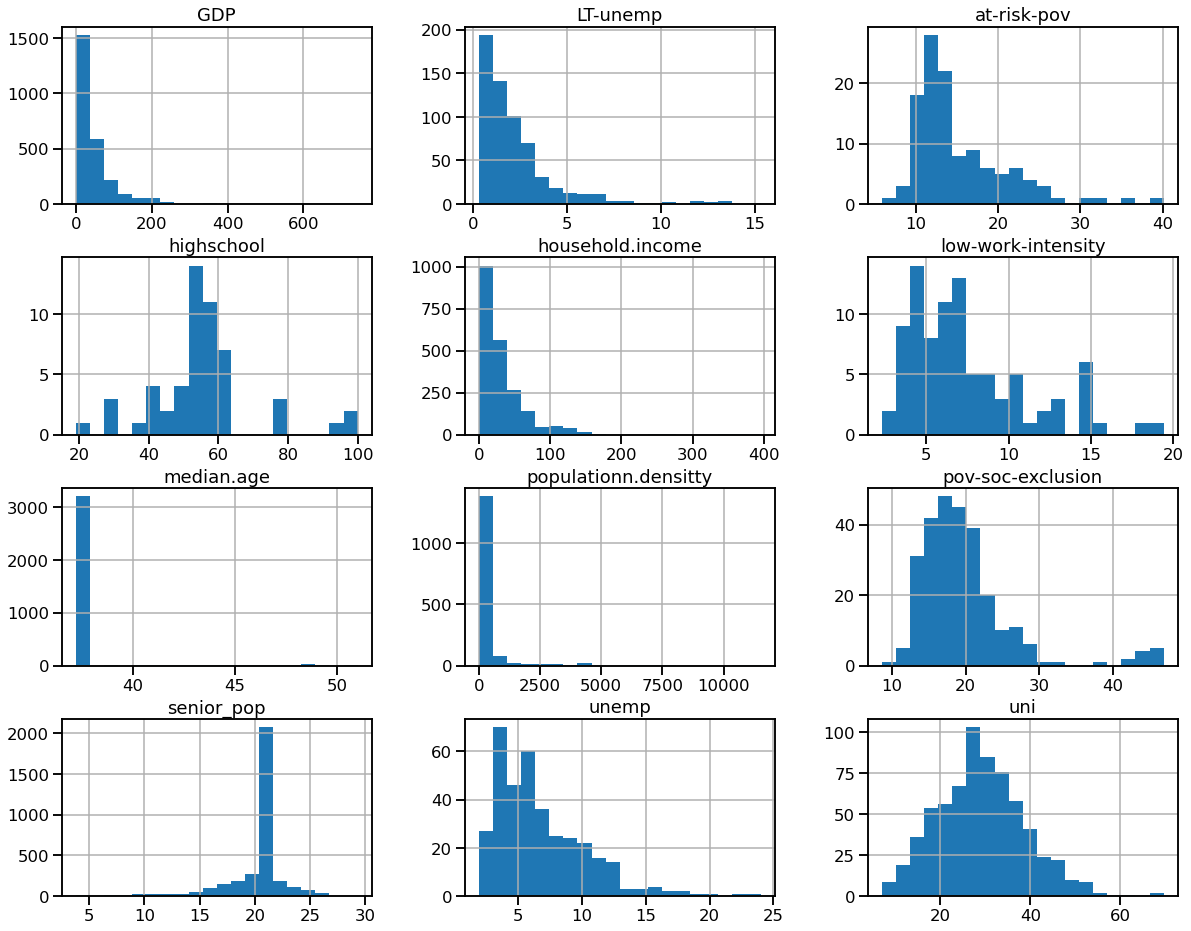

In [228]:
dataset[indep_vars_list].hist(bins=20, figsize=(20,16))

In [229]:
dataset

varDESC           gdp,r&d  hi-tech.emloy  household.bb  household.internet  \
TIME_PERIOD geo                                                              
2008        ES11      NaN            NaN           NaN                 NaN   
            ES12      NaN            NaN           NaN                 NaN   
            ES13      NaN            NaN           NaN                 NaN   
            ES21      NaN            NaN           NaN                 NaN   
            ES22      NaN            NaN           NaN                 NaN   
...                   ...            ...           ...                 ...   
2020        TRB1      NaN            0.3           NaN                 NaN   
            TRB2      NaN            0.1           NaN                 NaN   
            TRC1      NaN            0.5           NaN                 NaN   
            TRC2      NaN            0.6           NaN                 NaN   
            TRC3      NaN            0.3           NaN                 NaN   

varDESC           ind.freq.use.  ind.never.used  ind.ordered.online  \
TIME_PERIOD geo                                                       
2008        ES11            NaN            42.0                 NaN   
            ES12            NaN            34.0                 NaN   
            ES13            NaN            32.0                 NaN   
            ES21            NaN            30.0                 NaN   
            ES22            NaN            29.0                 NaN   
...                         ...             ...                 ...   
2020        TRB1            NaN             NaN                 NaN   
            TRB2            NaN             NaN                 NaN   
            TRC1            NaN             NaN                 NaN   
            TRC2            NaN             NaN                 NaN   
            TRC3            NaN             NaN                 NaN   

varDESC           uni.or.hi-tech  GDP  LT-unemp  at-risk-pov  highschool  \
TIME_PERIOD geo                                                            
2008        ES11             NaN  NaN       NaN         20.9         NaN   
            ES12             NaN  NaN       NaN         13.2         NaN   
            ES13             NaN  NaN       NaN         14.3         NaN   
            ES21             NaN  NaN       NaN          9.1         NaN   
            ES22             NaN  NaN       NaN          5.9         NaN   
...                          ...  ...       ...          ...         ...   
2020        TRB1            30.6  NaN       NaN          NaN         NaN   
            TRB2            19.8  NaN       NaN          NaN         NaN   
            TRC1            25.4  NaN       NaN          NaN         NaN   
            TRC2            19.1  NaN       NaN          NaN         NaN   
            TRC3            22.7  NaN       NaN          NaN         NaN   

varDESC           household.income  low-work-intensity  median.age  \
TIME_PERIOD geo                                                      
2008        ES11               NaN                 NaN        37.2   
            ES12               NaN                 NaN        37.2   
            ES13               NaN                 NaN        37.2   
            ES21               NaN                 NaN        37.2   
            ES22               NaN                 NaN        37.2   
...                            ...                 ...         ...   
2020        TRB1               NaN                 NaN         NaN   
            TRB2               NaN                 NaN         NaN   
            TRC1               NaN                 NaN         NaN   
            TRC2               NaN                 NaN         NaN   
            TRC3               NaN                 NaN         NaN   

varDESC           populationn.densitty  pov-soc-exclusion  senior_pop  unemp  \
TIME_PERIOD geo                                                                
2

#### MIN-MAX NORMALIZATION

In [230]:
from sklearn.preprocessing import minmax_scale
dataset_norm=dataset.groupby(level=0).transform(lambda x: minmax_scale(x.astype(float)))
dataset_norm

C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN sl

C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Andrea\anaconda3\envs\env_with_maps\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN sl

varDESC           gdp,r&d  hi-tech.emloy  household.bb  household.internet  \
TIME_PERIOD geo                                                              
2008        ES11      NaN            NaN           NaN                 NaN   
            ES12      NaN            NaN           NaN                 NaN   
            ES13      NaN            NaN           NaN                 NaN   
            ES21      NaN            NaN           NaN                 NaN   
            ES22      NaN            NaN           NaN                 NaN   
...                   ...            ...           ...                 ...   
2020        TRB1      NaN       0.015625           NaN                 NaN   
            TRB2      NaN       0.000000           NaN                 NaN   
            TRC1      NaN       0.031250           NaN                 NaN   
            TRC2      NaN       0.039062           NaN                 NaN   
            TRC3      NaN       0.015625           NaN                 NaN   

varDESC           ind.freq.use.  ind.never.used  ind.ordered.online  \
TIME_PERIOD geo                                                       
2008        ES11            NaN        1.000000                 NaN   
            ES12            NaN        0.555556                 NaN   
            ES13            NaN        0.444444                 NaN   
            ES21            NaN        0.333333                 NaN   
            ES22            NaN        0.277778                 NaN   
...                         ...             ...                 ...   
2020        TRB1            NaN             NaN                 NaN   
            TRB2            NaN             NaN                 NaN   
            TRC1            NaN             NaN                 NaN   
            TRC2            NaN             NaN                 NaN   
            TRC3            NaN             NaN                 NaN   

varDESC           uni.or.hi-tech  GDP  LT-unemp  at-risk-pov  highschool  \
TIME_PERIOD geo                                                            
2008        ES11             NaN  NaN       NaN     0.438596         NaN   
            ES12             NaN  NaN       NaN     0.213450         NaN   
            ES13             NaN  NaN       NaN     0.245614         NaN   
            ES21             NaN  NaN       NaN     0.093567         NaN   
            ES22             NaN  NaN       NaN     0.000000         NaN   
...                          ...  ...       ...          ...         ...   
2020        TRB1        0.273224  NaN       NaN          NaN         NaN   
            TRB2        0.076503  NaN       NaN          NaN         NaN   
            TRC1        0.178506  NaN       NaN          NaN         NaN   
            TRC2        0.063752  NaN       NaN          NaN         NaN   
            TRC3        0.129326  NaN       NaN          NaN         NaN   

varDESC           household.income  low-work-intensity  median.age  \
TIME_PERIOD geo                                                      
2008        ES11               NaN                 NaN         0.0   
            ES12               NaN                 NaN         0.0   
            ES13               NaN                 NaN         0.0   
            ES21               NaN                 NaN         0.0   
            ES22               NaN                 NaN         0.0   
...                            ...                 ...         ...   
2020        TRB1               NaN                 NaN         NaN   
            TRB2               NaN                 NaN         NaN   
            TRC1               NaN                 NaN         NaN   
            TRC2               NaN                 NaN         NaN   
            TRC3               NaN                 NaN         NaN   

varDESC           populationn.densitty  pov-soc-exclusion  senior_pop  unemp  \
TIME_PERIOD geo                                                                
2

array([[<AxesSubplot:title={'center':'gdp,r&d'}>,
        <AxesSubplot:title={'center':'hi-tech.emloy'}>,
        <AxesSubplot:title={'center':'household.bb'}>],
       [<AxesSubplot:title={'center':'household.internet'}>,
        <AxesSubplot:title={'center':'ind.freq.use.'}>,
        <AxesSubplot:title={'center':'ind.never.used'}>],
       [<AxesSubplot:title={'center':'ind.ordered.online'}>,
        <AxesSubplot:title={'center':'uni.or.hi-tech'}>, <AxesSubplot:>]],
      dtype=object)

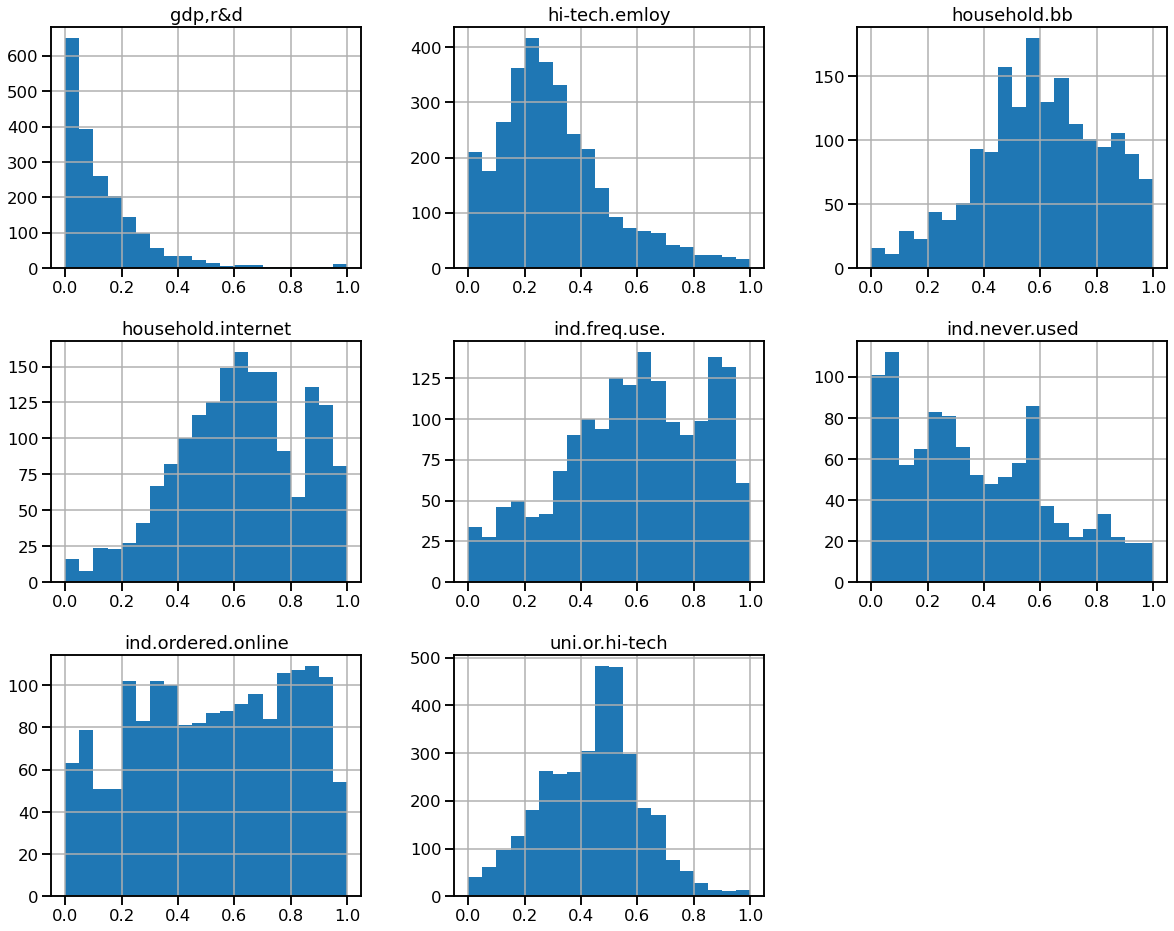

In [231]:
dataset_norm[dep_vars_list].hist(bins=20, figsize=(20,16))

array([[<AxesSubplot:title={'center':'GDP'}>,
        <AxesSubplot:title={'center':'LT-unemp'}>,
        <AxesSubplot:title={'center':'at-risk-pov'}>],
       [<AxesSubplot:title={'center':'highschool'}>,
        <AxesSubplot:title={'center':'household.income'}>,
        <AxesSubplot:title={'center':'low-work-intensity'}>],
       [<AxesSubplot:title={'center':'median.age'}>,
        <AxesSubplot:title={'center':'populationn.densitty'}>,
        <AxesSubplot:title={'center':'pov-soc-exclusion'}>],
       [<AxesSubplot:title={'center':'senior_pop'}>,
        <AxesSubplot:title={'center':'unemp'}>,
        <AxesSubplot:title={'center':'uni'}>]], dtype=object)

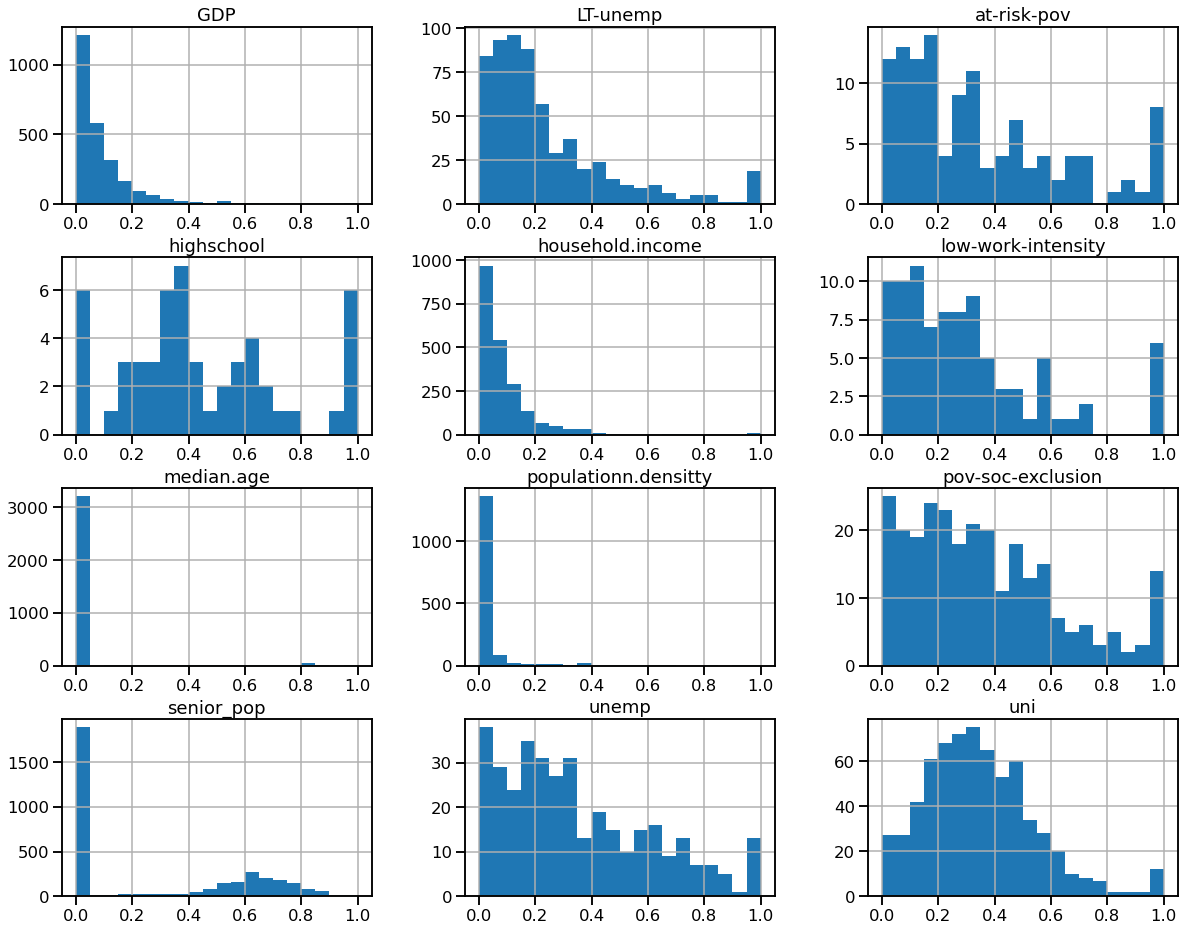

In [232]:
dataset_norm[indep_vars_list].hist(bins=20, figsize=(20,16))

In [233]:
dataset_norm["digitalization_indicator_norm"]=dataset_norm[dep_vars_list].mean(axis=1)
dataset_norm

varDESC           gdp,r&d  hi-tech.emloy  household.bb  household.internet  \
TIME_PERIOD geo                                                              
2008        ES11      NaN            NaN           NaN                 NaN   
            ES12      NaN            NaN           NaN                 NaN   
            ES13      NaN            NaN           NaN                 NaN   
            ES21      NaN            NaN           NaN                 NaN   
            ES22      NaN            NaN           NaN                 NaN   
...                   ...            ...           ...                 ...   
2020        TRB1      NaN       0.015625           NaN                 NaN   
            TRB2      NaN       0.000000           NaN                 NaN   
            TRC1      NaN       0.031250           NaN                 NaN   
            TRC2      NaN       0.039062           NaN                 NaN   
            TRC3      NaN       0.015625           NaN                 NaN   

varDESC           ind.freq.use.  ind.never.used  ind.ordered.online  \
TIME_PERIOD geo                                                       
2008        ES11            NaN        1.000000                 NaN   
            ES12            NaN        0.555556                 NaN   
            ES13            NaN        0.444444                 NaN   
            ES21            NaN        0.333333                 NaN   
            ES22            NaN        0.277778                 NaN   
...                         ...             ...                 ...   
2020        TRB1            NaN             NaN                 NaN   
            TRB2            NaN             NaN                 NaN   
            TRC1            NaN             NaN                 NaN   
            TRC2            NaN             NaN                 NaN   
            TRC3            NaN             NaN                 NaN   

varDESC           uni.or.hi-tech  GDP  LT-unemp  at-risk-pov  highschool  \
TIME_PERIOD geo                                                            
2008        ES11             NaN  NaN       NaN     0.438596         NaN   
            ES12             NaN  NaN       NaN     0.213450         NaN   
            ES13             NaN  NaN       NaN     0.245614         NaN   
            ES21             NaN  NaN       NaN     0.093567         NaN   
            ES22             NaN  NaN       NaN     0.000000         NaN   
...                          ...  ...       ...          ...         ...   
2020        TRB1        0.273224  NaN       NaN          NaN         NaN   
            TRB2        0.076503  NaN       NaN          NaN         NaN   
            TRC1        0.178506  NaN       NaN          NaN         NaN   
            TRC2        0.063752  NaN       NaN          NaN         NaN   
            TRC3        0.129326  NaN       NaN          NaN         NaN   

varDESC           household.income  low-work-intensity  median.age  \
TIME_PERIOD geo                                                      
2008        ES11               NaN                 NaN         0.0   
            ES12               NaN                 NaN         0.0   
            ES13               NaN                 NaN         0.0   
            ES21               NaN                 NaN         0.0   
            ES22               NaN                 NaN         0.0   
...                            ...                 ...         ...   
2020        TRB1               NaN                 NaN         NaN   
            TRB2               NaN                 NaN         NaN   
            TRC1               NaN                 NaN         NaN   
            TRC2               NaN                 NaN         NaN   
            TRC3               NaN                 NaN         NaN   

varDESC           populationn.densitty  pov-soc-exclusion  senior_pop  unemp  \
TIME_PERIOD geo                                                                
2

<AxesSubplot:>

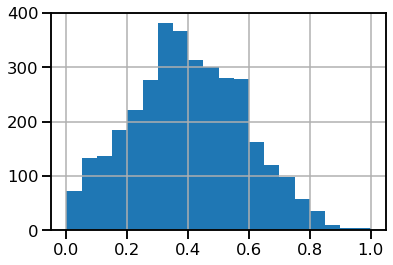

In [234]:
dataset_norm["digitalization_indicator_norm"].hist(bins=20)

<AxesSubplot:xlabel='TIME_PERIOD'>

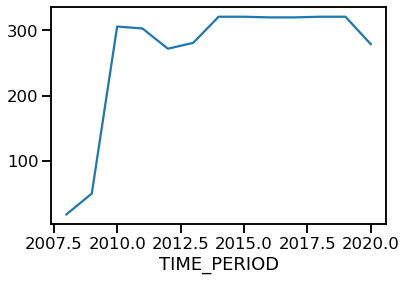

In [235]:
dataset_norm.groupby(level=0)["digitalization_indicator_norm"].size().plot()

#### STANDARDIZATION

In [236]:
dataset_stdev=dataset.groupby(level=0).transform(lambda x: (x.astype(float) - x.astype(float).mean()) / x.astype(float).std())
dataset_stdev

varDESC           gdp,r&d  hi-tech.emloy  household.bb  household.internet  \
TIME_PERIOD geo                                                              
2008        ES11      NaN            NaN           NaN                 NaN   
            ES12      NaN            NaN           NaN                 NaN   
            ES13      NaN            NaN           NaN                 NaN   
            ES21      NaN            NaN           NaN                 NaN   
            ES22      NaN            NaN           NaN                 NaN   
...                   ...            ...           ...                 ...   
2020        TRB1      NaN      -1.469301           NaN                 NaN   
            TRB2      NaN      -1.551603           NaN                 NaN   
            TRC1      NaN      -1.386999           NaN                 NaN   
            TRC2      NaN      -1.345848           NaN                 NaN   
            TRC3      NaN      -1.469301           NaN                 NaN   

varDESC           ind.freq.use.  ind.never.used  ind.ordered.online  \
TIME_PERIOD geo                                                       
2008        ES11            NaN        1.548055                 NaN   
            ES12            NaN        0.000000                 NaN   
            ES13            NaN       -0.387014                 NaN   
            ES21            NaN       -0.774028                 NaN   
            ES22            NaN       -0.967535                 NaN   
...                         ...             ...                 ...   
2020        TRB1            NaN             NaN                 NaN   
            TRB2            NaN             NaN                 NaN   
            TRC1            NaN             NaN                 NaN   
            TRC2            NaN             NaN                 NaN   
            TRC3            NaN             NaN                 NaN   

varDESC           uni.or.hi-tech  GDP  LT-unemp  at-risk-pov  highschool  \
TIME_PERIOD geo                                                            
2008        ES11             NaN  NaN       NaN     0.152458         NaN   
            ES12             NaN  NaN       NaN    -0.727989         NaN   
            ES13             NaN  NaN       NaN    -0.602211         NaN   
            ES21             NaN  NaN       NaN    -1.196799         NaN   
            ES22             NaN  NaN       NaN    -1.562699         NaN   
...                          ...  ...       ...          ...         ...   
2020        TRB1       -1.171927  NaN       NaN          NaN         NaN   
            TRB2       -2.153948  NaN       NaN          NaN         NaN   
            TRC1       -1.644752  NaN       NaN          NaN         NaN   
            TRC2       -2.217597  NaN       NaN          NaN         NaN   
            TRC3       -1.890257  NaN       NaN          NaN         NaN   

varDESC           household.income  low-work-intensity  median.age  \
TIME_PERIOD geo                                                      
2008        ES11               NaN                 NaN   -0.971825   
            ES12               NaN                 NaN   -0.971825   
            ES13               NaN                 NaN   -0.971825   
            ES21               NaN                 NaN   -0.971825   
            ES22               NaN                 NaN   -0.971825   
...                            ...                 ...         ...   
2020        TRB1               NaN                 NaN         NaN   
            TRB2               NaN                 NaN         NaN   
            TRC1               NaN                 NaN         NaN   
            TRC2               NaN                 NaN         NaN   
            TRC3               NaN                 NaN         NaN   

varDESC           populationn.densitty  pov-soc-exclusion  senior_pop  unemp  \
TIME_PERIOD geo                                                                
2

array([[<AxesSubplot:title={'center':'gdp,r&d'}>,
        <AxesSubplot:title={'center':'hi-tech.emloy'}>,
        <AxesSubplot:title={'center':'household.bb'}>],
       [<AxesSubplot:title={'center':'household.internet'}>,
        <AxesSubplot:title={'center':'ind.freq.use.'}>,
        <AxesSubplot:title={'center':'ind.never.used'}>],
       [<AxesSubplot:title={'center':'ind.ordered.online'}>,
        <AxesSubplot:title={'center':'uni.or.hi-tech'}>, <AxesSubplot:>]],
      dtype=object)

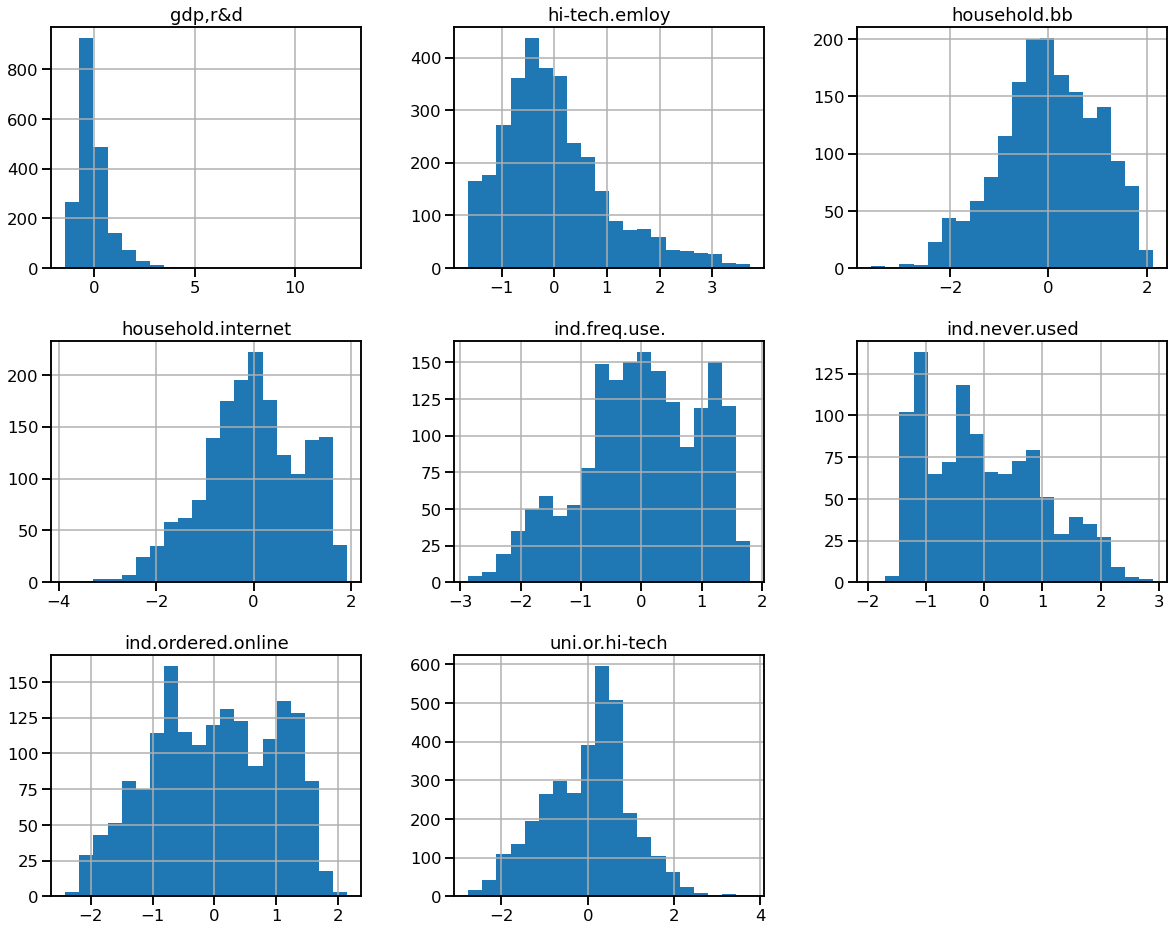

In [237]:
dataset_stdev[dep_vars_list].hist(bins=20, figsize=(20,16))

array([[<AxesSubplot:title={'center':'GDP'}>,
        <AxesSubplot:title={'center':'LT-unemp'}>,
        <AxesSubplot:title={'center':'at-risk-pov'}>],
       [<AxesSubplot:title={'center':'highschool'}>,
        <AxesSubplot:title={'center':'household.income'}>,
        <AxesSubplot:title={'center':'low-work-intensity'}>],
       [<AxesSubplot:title={'center':'median.age'}>,
        <AxesSubplot:title={'center':'populationn.densitty'}>,
        <AxesSubplot:title={'center':'pov-soc-exclusion'}>],
       [<AxesSubplot:title={'center':'senior_pop'}>,
        <AxesSubplot:title={'center':'unemp'}>,
        <AxesSubplot:title={'center':'uni'}>]], dtype=object)

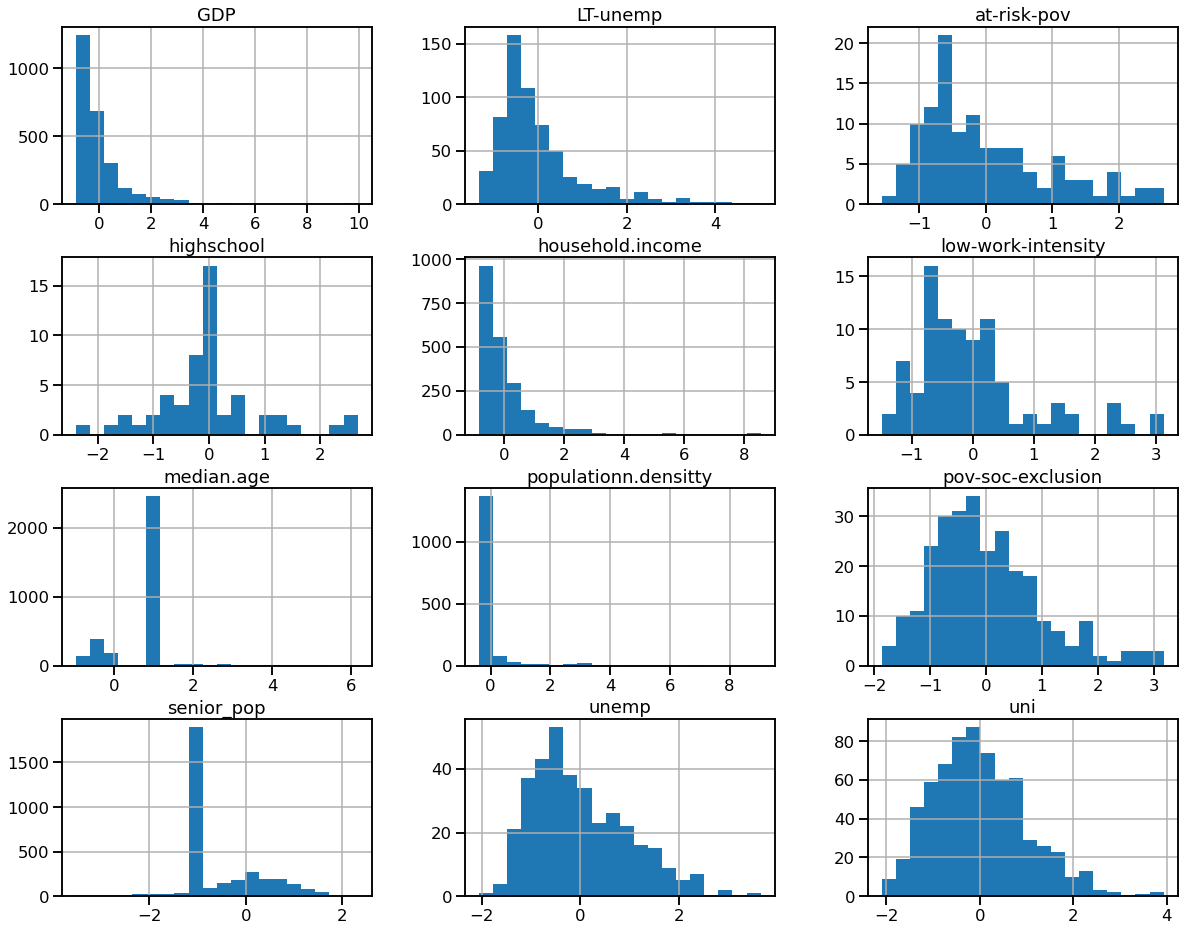

In [238]:
dataset_stdev[indep_vars_list].hist(bins=20, figsize=(20,16))

In [239]:
dataset_stdev["digitalization_indicator_stdev"]=dataset_stdev[dep_vars_list].mean(axis=1)
dataset_stdev

varDESC           gdp,r&d  hi-tech.emloy  household.bb  household.internet  \
TIME_PERIOD geo                                                              
2008        ES11      NaN            NaN           NaN                 NaN   
            ES12      NaN            NaN           NaN                 NaN   
            ES13      NaN            NaN           NaN                 NaN   
            ES21      NaN            NaN           NaN                 NaN   
            ES22      NaN            NaN           NaN                 NaN   
...                   ...            ...           ...                 ...   
2020        TRB1      NaN      -1.469301           NaN                 NaN   
            TRB2      NaN      -1.551603           NaN                 NaN   
            TRC1      NaN      -1.386999           NaN                 NaN   
            TRC2      NaN      -1.345848           NaN                 NaN   
            TRC3      NaN      -1.469301           NaN                 NaN   

varDESC           ind.freq.use.  ind.never.used  ind.ordered.online  \
TIME_PERIOD geo                                                       
2008        ES11            NaN        1.548055                 NaN   
            ES12            NaN        0.000000                 NaN   
            ES13            NaN       -0.387014                 NaN   
            ES21            NaN       -0.774028                 NaN   
            ES22            NaN       -0.967535                 NaN   
...                         ...             ...                 ...   
2020        TRB1            NaN             NaN                 NaN   
            TRB2            NaN             NaN                 NaN   
            TRC1            NaN             NaN                 NaN   
            TRC2            NaN             NaN                 NaN   
            TRC3            NaN             NaN                 NaN   

varDESC           uni.or.hi-tech  GDP  LT-unemp  at-risk-pov  highschool  \
TIME_PERIOD geo                                                            
2008        ES11             NaN  NaN       NaN     0.152458         NaN   
            ES12             NaN  NaN       NaN    -0.727989         NaN   
            ES13             NaN  NaN       NaN    -0.602211         NaN   
            ES21             NaN  NaN       NaN    -1.196799         NaN   
            ES22             NaN  NaN       NaN    -1.562699         NaN   
...                          ...  ...       ...          ...         ...   
2020        TRB1       -1.171927  NaN       NaN          NaN         NaN   
            TRB2       -2.153948  NaN       NaN          NaN         NaN   
            TRC1       -1.644752  NaN       NaN          NaN         NaN   
            TRC2       -2.217597  NaN       NaN          NaN         NaN   
            TRC3       -1.890257  NaN       NaN          NaN         NaN   

varDESC           household.income  low-work-intensity  median.age  \
TIME_PERIOD geo                                                      
2008        ES11               NaN                 NaN   -0.971825   
            ES12               NaN                 NaN   -0.971825   
            ES13               NaN                 NaN   -0.971825   
            ES21               NaN                 NaN   -0.971825   
            ES22               NaN                 NaN   -0.971825   
...                            ...                 ...         ...   
2020        TRB1               NaN                 NaN         NaN   
            TRB2               NaN                 NaN         NaN   
            TRC1               NaN                 NaN         NaN   
            TRC2               NaN                 NaN         NaN   
            TRC3               NaN                 NaN         NaN   

varDESC           populationn.densitty  pov-soc-exclusion  senior_pop  unemp  \
TIME_PERIOD geo                                                                
2

<AxesSubplot:>

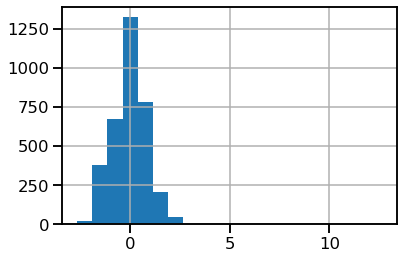

In [240]:
dataset_stdev["digitalization_indicator_stdev"].hist(bins=20)

<AxesSubplot:xlabel='TIME_PERIOD'>

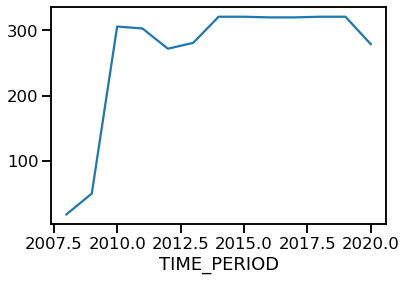

In [241]:
dataset_stdev.groupby(level=0)["digitalization_indicator_stdev"].size().plot()

Years filtering

In [242]:
dataset_norm=dataset_norm.loc[idx[2010:2019,:]]
dataset_stdev=dataset_stdev.loc[idx[2010:2019,:]]

<AxesSubplot:xlabel='TIME_PERIOD'>

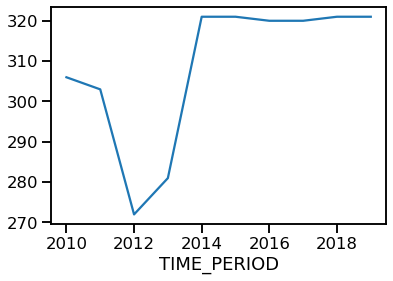

In [243]:
dataset_norm.groupby(level=0)["digitalization_indicator_norm"].size().plot()

<AxesSubplot:xlabel='TIME_PERIOD'>

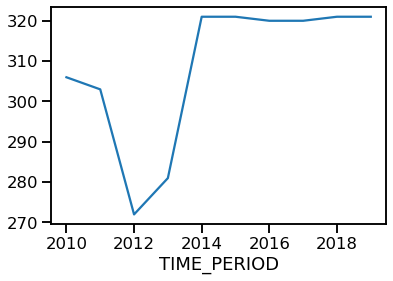

In [244]:
dataset_stdev.groupby(level=0)["digitalization_indicator_stdev"].size().plot()

In [245]:
dataset_norm["country"]=dataset_norm.index.get_level_values(1).str[0:2]

C:\Users\Andrea\AppData\Local\Temp\ipykernel_45316\2149921868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_norm["country"]=dataset_norm.index.get_level_values(1).str[0:2]


In [246]:
dataset_stdev["country"]=dataset_stdev.index.get_level_values(1).str[0:2]

C:\Users\Andrea\AppData\Local\Temp\ipykernel_45316\319534160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_stdev["country"]=dataset_stdev.index.get_level_values(1).str[0:2]


<AxesSubplot:xlabel='country'>

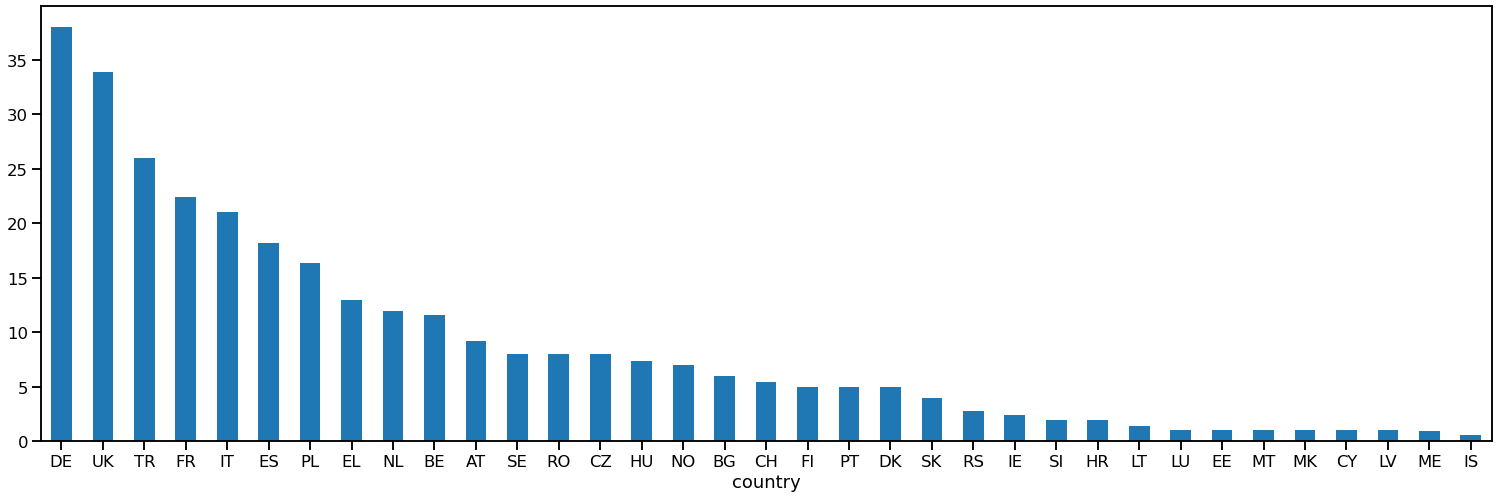

In [247]:
a=dataset_norm.groupby("country")["digitalization_indicator_norm"].size()/10 #10 is the number of years, therefore the statistic is average number of regions available for each country across the 10 years
a.sort_values(ascending=False, inplace=True)
a.plot.bar(x="country", y='digitalization_indicator_norm', rot=0, figsize=(26,8))

<AxesSubplot:xlabel='country'>

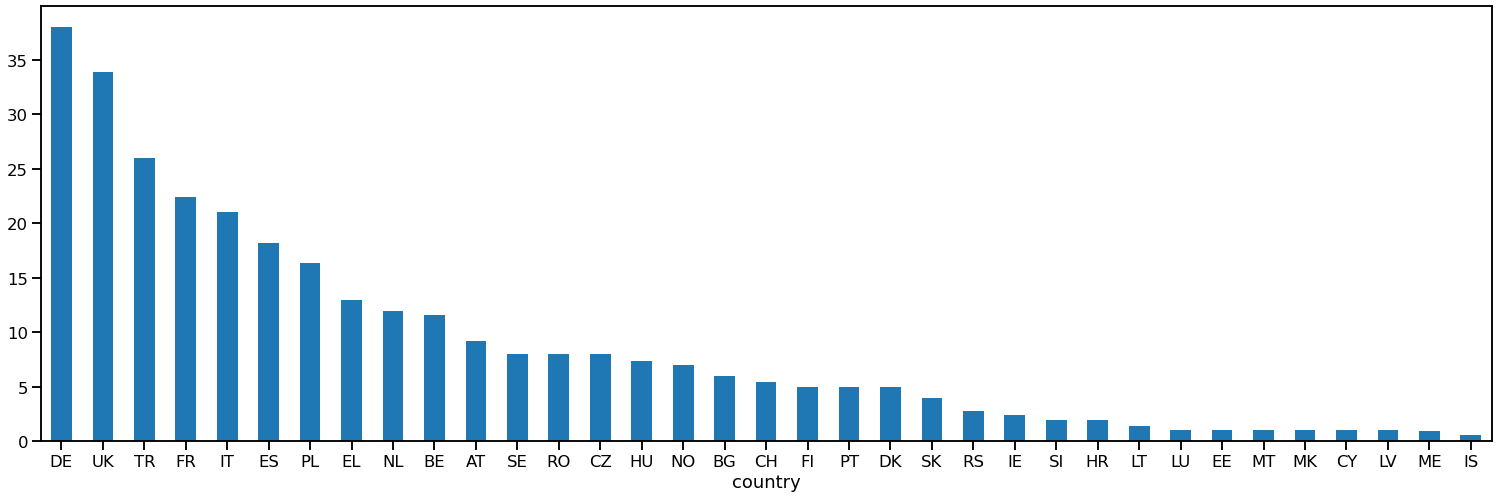

In [248]:
a=dataset_stdev.groupby("country")["digitalization_indicator_stdev"].size()/10 #10 is the number of years, therefore the statistic is average number of regions available for each country across the 10 years
a.sort_values(ascending=False, inplace=True)
a.plot.bar(x="country", y='digitalization_indicator_stdev', rot=0, figsize=(26,8))

<AxesSubplot:xlabel='country'>

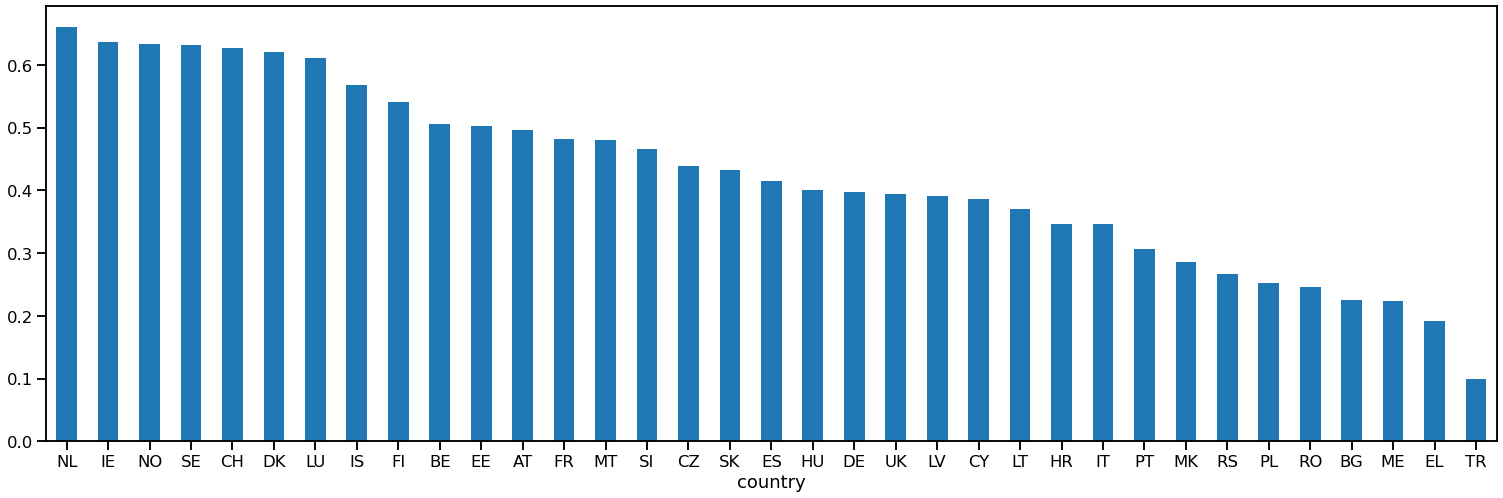

In [249]:
a=dataset_norm.groupby("country")["digitalization_indicator_norm"].mean() #average indicator value for each country
a.sort_values(ascending=False, inplace=True)
a.plot.bar(x="country", y='digitalization_indicator', rot=0, figsize=(26,8))


<AxesSubplot:xlabel='country'>

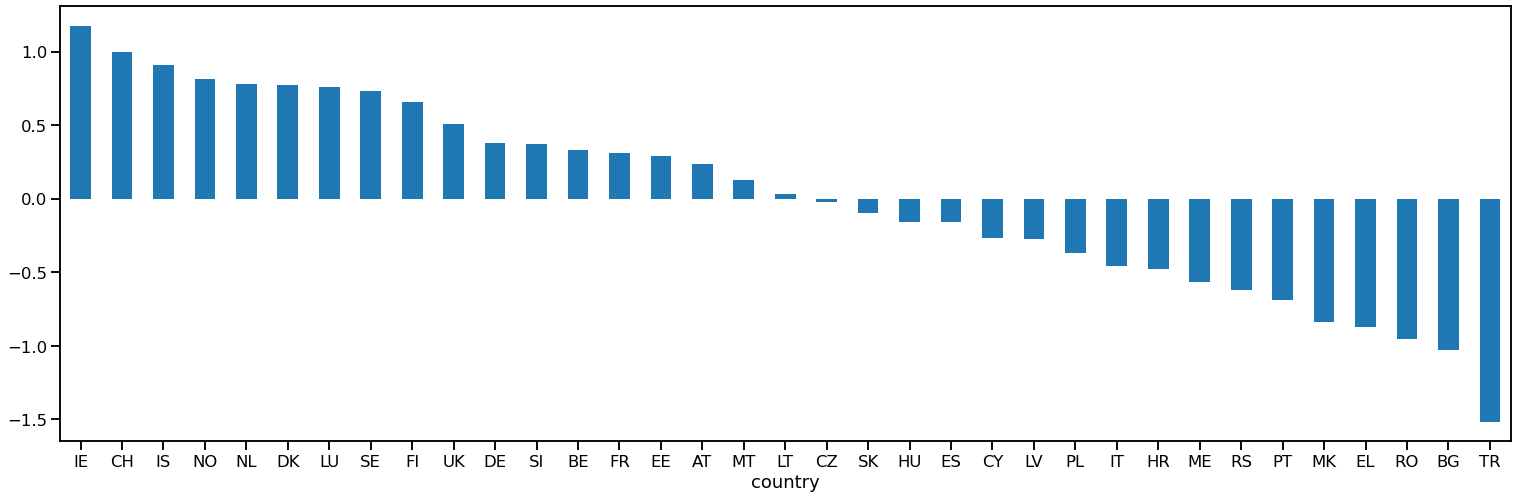

In [250]:
a=dataset_stdev.groupby("country")["digitalization_indicator_stdev"].mean() #average indicator value for each country
a.sort_values(ascending=False, inplace=True)
a.plot.bar(x="country", y='digitalization_indicator_stdev', rot=0, figsize=(26,8))


In [251]:
dataset_norm.to_csv("./data/final_dataset_norm.csv")

In [252]:
dataset_stdev.to_csv("./data/final_dataset_stdev.csv")

# MODEL ESTIMATION NORMALIZED DATA

To do:

    1. fix effect
        Robustness check
        - run individuals panelOLS on the 8 subindicators
        - re-include 2008,2009,2020
        - entity and/or time effect
        - estimate reduced model (including only a set of the 10 regressors) drop the variables with a lot of missing data
   
   2. random effect (maybe)
    

## FIXED-EFFECT ESTIMATOR

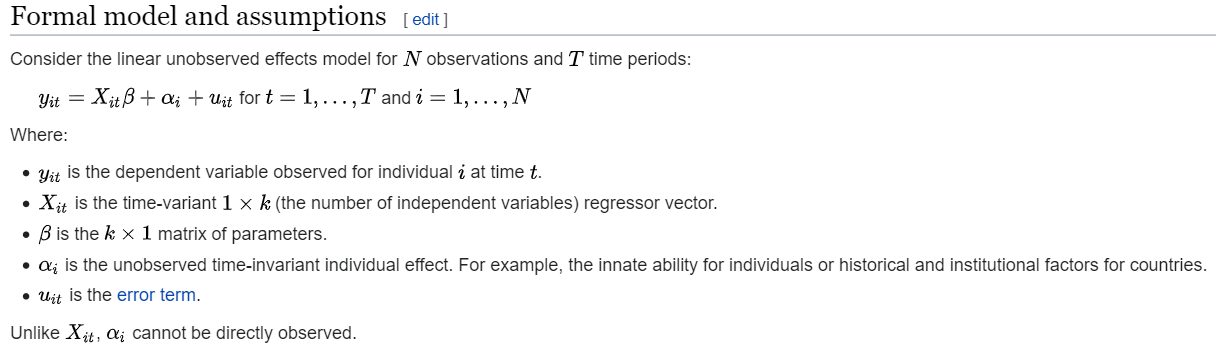

In [271]:
dataset_norm.index=dataset_norm.index.reorder_levels([1,0])
dataset_norm

,varDESC,"gdp,r&d",hi-tech.emloy,household.bb,household.internet,ind.freq.use.,ind.never.used,ind.ordered.online,uni.or.hi-tech,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni,digitalization_indicator_norm,country
geo,TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,,
AT11,2010,NaN,0.232323,0.666667,0.657143,0.545455,0.368421,0.493671,0.352751,0.016237,NaN,NaN,NaN,0.016451,NaN,0.0,NaN,NaN,0.000000,0.078261,NaN,0.473776,AT
AT12,2010,NaN,0.323232,0.652778,0.671429,0.636364,0.280702,0.531646,0.412621,0.129825,NaN,NaN,NaN,0.110407,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.501253,AT
AT13,2010,NaN,0.666667,0.736111,0.685714,0.696970,0.298246,0.556962,0.543689,0.221195,NaN,NaN,NaN,0.113819,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.597766,AT
AT21,2010,NaN,0.333333,0.583333,0.614286,0.545455,0.368421,0.430380,0.326861,0.044596,NaN,NaN,NaN,0.032667,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.457438,AT
AT22,2010,NaN,0.303030,0.666667,0.671429,0.621212,0.315789,0.506329,0.349515,0.104834,NaN,NaN,NaN,0.074628,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.490567,AT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,2019,NaN,0.245763,NaN,NaN,NaN,NaN,NaN,0.581465,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.754032,NaN,NaN,0.413614,UK
UKM7,2019,NaN,0.330508,NaN,NaN,NaN,NaN,NaN,0.707025,NaN,0.172414,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.584677,NaN,NaN,0.518767,UK
UKM8,2019,NaN,0.330508,NaN,NaN,NaN,NaN,NaN,0.692078,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.512097,NaN,NaN,0.511293,UK


In [272]:
dataset_norm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3086 entries, ('AT11', 2010) to ('UKN0', 2019)
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gdp,r&d                        1924 non-null   float64
 1   hi-tech.emloy                  2901 non-null   float64
 2   household.bb                   1558 non-null   float64
 3   household.internet             1566 non-null   float64
 4   ind.freq.use.                  1566 non-null   float64
 5   ind.never.used                 1033 non-null   float64
 6   ind.ordered.online             1566 non-null   float64
 7   uni.or.hi-tech                 3072 non-null   float64
 8   GDP                            2566 non-null   float64
 9   LT-unemp                       526 non-null    float64
 10  at-risk-pov                    75 non-null     float64
 11  highschool                     53 non-null     float64
 12  household.income         

In [273]:
indep_vars_list

['GDP',
 'LT-unemp',
 'at-risk-pov',
 'highschool',
 'household.income',
 'low-work-intensity',
 'median.age',
 'populationn.densitty',
 'pov-soc-exclusion',
 'senior_pop',
 'unemp',
 'uni']

In [274]:
["digitalization_indicator_norm"]+indep_vars_list
dep_vars_list=["digitalization_indicator_norm"]+dep_vars_list
dep_vars_list

['digitalization_indicator_norm',
 'digitalization_indicator_norm',
 'gdp,r&d',
 'hi-tech.emloy',
 'household.bb',
 'household.internet',
 'ind.freq.use.',
 'ind.never.used',
 'ind.ordered.online',
 'uni.or.hi-tech']

In [275]:
dataset_norm[dep_vars_list[0]].index.get_level_values(1).nunique()
dataset_norm.loc[:,indep_vars_list].index.get_level_values(1).nunique()

10

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html

In [276]:
from linearmodels import PanelOLS

In [277]:
#INPUTS
Y=dataset_norm[dep_vars_list[0]].fillna(0)
X=dataset_norm.loc[:,indep_vars_list].fillna(0)

In [278]:
# import statsmodels.api as sm
mod = PanelOLS(Y, #X
               X, #Y
               entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_norm,R-squared:,0.1274
Estimator:,PanelOLS,R-squared (Between):,0.0747
No. Observations:,3086,R-squared (Within):,0.1274
Date:,"Wed, Apr 13 2022",R-squared (Overall):,0.0756
Time:,00:31:10,Log-likelihood,4795.1
Cov. Estimator:,Clustered,,
,,F-statistic:,33.436
Entities:,326,P-value,0.0000
Avg Obs:,9.4663,Distribution:,"F(12,2748)"
Min Obs:,2.0000,,
Max Obs:,10.0000,F-statistic (robust):,26.154


In [279]:
np.array(res.summary)

array(<class 'linearmodels.compat.statsmodels.Summary'>
"""
                                PanelOLS Estimation Summary                                
Dep. Variable:     digitalization_indicator_norm   R-squared:                        0.1274
Estimator:                              PanelOLS   R-squared (Between):              0.0747
No. Observations:                           3086   R-squared (Within):               0.1274
Date:                           Wed, Apr 13 2022   R-squared (Overall):              0.0756
Time:                                   00:31:10   Log-likelihood                    4795.1
Cov. Estimator:                        Clustered                                           
                                                   F-statistic:                      33.436
Entities:                                    326   P-value                           0.0000
Avg Obs:                                  9.4663   Distribution:                 F(12,2748)
Min Obs:            

In [280]:
# import statsmodels.api as sm
mod = PanelOLS(Y,
               X,
               entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_norm,R-squared:,0.0428
Estimator:,PanelOLS,R-squared (Between):,0.0374
No. Observations:,3086,R-squared (Within):,0.0353
Date:,"Wed, Apr 13 2022",R-squared (Overall):,0.0392
Time:,00:31:20,Log-likelihood,5107.7
Cov. Estimator:,Clustered,,
,,F-statistic:,10.196
Entities:,326,P-value,0.0000
Avg Obs:,9.4663,Distribution:,"F(12,2739)"
Min Obs:,2.0000,,
Max Obs:,10.0000,F-statistic (robust):,9.5634


### ROBUSTNESS TEST

In the robusteness tests only entity effects of the baseline models are included.
The dimensions of the study along which the robustness tests are conducted are:

    1. time dimension:
        1. model with time-series average of the X and Y -> cross-sectional regression
        2. split the sample in half: before and after 2005
        
    2. entity
        1. countries Panel Data regression
        2. randomly sample half of the entities
        3. rich countries and poor regions (above and below median)
        

#### ROBUSTNESS TEST 1.1 (TIME-SERIES AVERAGE)

In [281]:
import statsmodels.api as sm

In [282]:
Y.groupby(level=0).mean()

geo
AT11    0.466092
AT12    0.502245
AT13    0.611161
AT21    0.479377
AT22    0.504168
          ...   
UKM6    0.286210
UKM7    0.478883
UKM8    0.428896
UKM9    0.304438
UKN0    0.323251
Name: digitalization_indicator_norm, Length: 326, dtype: float64

In [283]:
X.groupby(level=0).mean()

varDESC,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni
geo,,,,,,,,,,,,
AT11,0.015442,0.000000,0.081591,0.0,0.018600,0.030725,0.000000,0.003671,0.055078,0.283897,0.086239,0.029872
AT12,0.110135,0.000000,0.014286,0.0,0.122084,0.083952,0.000000,0.004136,0.016275,0.259476,0.000000,0.035304
AT13,0.181612,0.000000,0.421497,0.0,0.124609,0.466667,0.000000,0.230857,0.376160,0.205318,0.000000,0.051278
AT21,0.038217,0.124836,0.104768,0.0,0.035722,0.217198,0.000000,0.002757,0.110928,0.281864,0.000000,0.034824
AT22,0.089823,0.014345,0.160807,0.0,0.083232,0.190667,0.000000,0.003553,0.129923,0.261507,0.000000,0.029872
...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,0.000000,0.052869,0.000000,0.0,0.000000,0.000000,0.002336,0.000367,0.000000,0.375245,0.011236,0.202020
UKM7,0.000000,0.067454,0.000000,0.0,0.000000,0.000000,0.003115,0.008640,0.000000,0.390362,0.000000,0.116081
UKM8,0.000000,0.009333,0.000000,0.0,0.000000,0.000000,0.003115,0.046784,0.000000,0.344887,0.000000,0.102236


In [284]:
mod = sm.OLS(Y.groupby(level=0).mean(),
             X.groupby(level=0).mean())
res = mod.fit()
print(res.summary())

                                      OLS Regression Results                                      
Dep. Variable:     digitalization_indicator_norm   R-squared (uncentered):                   0.890
Model:                                       OLS   Adj. R-squared (uncentered):              0.886
Method:                            Least Squares   F-statistic:                              211.3
Date:                           Wed, 13 Apr 2022   Prob (F-statistic):                   2.05e-142
Time:                                   00:31:51   Log-Likelihood:                          171.77
No. Observations:                            326   AIC:                                     -319.5
Df Residuals:                                314   BIC:                                     -274.1
Df Model:                                     12                                                  
Covariance Type:                       nonrobust                                                  
          

#### ROBUSTNESS TEST 1.2 (SPLIT THE SAMPLE ALONG T IN HALF)

**BEFORE 2015 (INCLUDED)**

In [285]:
X[X.index.get_level_values(1)<=2015]

,varDESC,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni
geo,TIME_PERIOD,,,,,,,,,,,,
AT11,2010,0.016237,0.0,0.0,0.0,0.016451,0.0,0.0,0.000000,0.0,0.0,0.078261,0.0
AT12,2010,0.129825,0.0,0.0,0.0,0.110407,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
AT13,2010,0.221195,0.0,0.0,0.0,0.113819,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
AT21,2010,0.044596,0.0,0.0,0.0,0.032667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
AT22,2010,0.104834,0.0,0.0,0.0,0.074628,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,2015,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000753,0.0,0.0,0.000000,0.0
UKM7,2015,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.013105,0.0,0.0,0.000000,0.0
UKM8,2015,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.071020,0.0,0.0,0.000000,0.0


In [286]:
Y[Y.index.get_level_values(1)<=2015]

geo   TIME_PERIOD
AT11  2010           0.473776
AT12  2010           0.501253
AT13  2010           0.597766
AT21  2010           0.457438
AT22  2010           0.490567
                       ...   
UKM6  2015           0.261024
UKM7  2015           0.447080
UKM8  2015           0.393529
UKM9  2015           0.265039
UKN0  2015           0.314008
Name: digitalization_indicator_norm, Length: 1804, dtype: float64

In [287]:
mod = sm.OLS(Y[Y.index.get_level_values(1)<=2015],
             X[X.index.get_level_values(1)<=2015])
res = mod.fit()
print(res.summary())

                                      OLS Regression Results                                      
Dep. Variable:     digitalization_indicator_norm   R-squared (uncentered):                   0.595
Model:                                       OLS   Adj. R-squared (uncentered):              0.593
Method:                            Least Squares   F-statistic:                              263.8
Date:                           Wed, 13 Apr 2022   Prob (F-statistic):                        0.00
Time:                                   00:31:58   Log-Likelihood:                         -148.41
No. Observations:                           1804   AIC:                                      316.8
Df Residuals:                               1794   BIC:                                      371.8
Df Model:                                     10                                                  
Covariance Type:                       nonrobust                                                  
          

**AFTER 2015 (INCLUDED)**

In [288]:
X[X.index.get_level_values(1)>2015]

,varDESC,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni
geo,TIME_PERIOD,,,,,,,,,,,,
AT11,2016,0.010203,0.000000,0.133929,0.0,0.017093,0.000000,0.0,0.006796,0.063253,0.700820,0.0,0.0
AT12,2016,0.079192,0.000000,0.000000,0.0,0.116340,0.093333,0.0,0.007537,0.000000,0.651639,0.0,0.0
AT13,2016,0.132331,0.000000,0.473214,0.0,0.118102,0.666667,0.0,0.418830,0.391566,0.528689,0.0,0.0
AT21,2016,0.025898,0.277778,0.058036,0.0,0.033144,0.373333,0.0,0.005054,0.099398,0.696721,0.0,0.0
AT22,2016,0.064540,0.000000,0.214286,0.0,0.078289,0.313333,0.0,0.006492,0.162651,0.651639,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,2019,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.754032,0.0,0.0
UKM7,2019,0.000000,0.172414,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.584677,0.0,0.0
UKM8,2019,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.512097,0.0,0.0


In [289]:
Y[Y.index.get_level_values(1)>2015]

geo   TIME_PERIOD
AT11  2016           0.517442
AT12  2016           0.570228
AT13  2016           0.680689
AT21  2016           0.535920
AT22  2016           0.524206
                       ...   
UKM6  2019           0.413614
UKM7  2019           0.518767
UKM8  2019           0.511293
UKM9  2019           0.407875
UKN0  2019           0.436802
Name: digitalization_indicator_norm, Length: 1282, dtype: float64

In [290]:
mod = sm.OLS(Y[Y.index.get_level_values(1)>2015],
             X[X.index.get_level_values(1)>2015])
res = mod.fit()
print(res.summary())

                                      OLS Regression Results                                      
Dep. Variable:     digitalization_indicator_norm   R-squared (uncentered):                   0.854
Model:                                       OLS   Adj. R-squared (uncentered):              0.853
Method:                            Least Squares   F-statistic:                              620.0
Date:                           Wed, 13 Apr 2022   Prob (F-statistic):                        0.00
Time:                                   00:32:01   Log-Likelihood:                          418.43
No. Observations:                           1282   AIC:                                     -812.9
Df Residuals:                               1270   BIC:                                     -751.0
Df Model:                                     12                                                  
Covariance Type:                       nonrobust                                                  
          

#### ROBUSTNESS TEST 2.1 (COUNTRY TEST)

In [291]:
X_country=X.copy()
X_country.loc[:,"country"]=X_country.index.get_level_values(0).str[:2]
X_country=X_country.droplevel(0).reset_index().set_index(["country","TIME_PERIOD"]).groupby(level=[0,1]).mean()
X_country

varDESC                   GDP  LT-unemp  at-risk-pov  highschool  \
country TIME_PERIOD                                                
AT      2010         0.091311  0.000000     0.000000         0.0   
        2011         0.086357  0.000775     0.000000         0.0   
        2012         0.100032  0.006667     0.000000         0.0   
        2013         0.092722  0.027778     0.000000         0.0   
        2014         0.103451  0.009630     0.298535         0.0   
...                       ...       ...          ...         ...   
UK      2015         0.000000  0.040650     0.000000         0.0   
        2016         0.000000  0.047425     0.000000         0.0   
        2017         0.000000  0.019317     0.000000         0.0   
        2018         0.000000  0.062852     0.000000         0.0   
        2019         0.000000  0.094197     0.000000         0.0   

varDESC              household.income  low-work-intensity  median.age  \
country TIME_PERIOD                                                     
AT      2010                 0.060611            0.000000    0.000000   
        2011                 0.056764            0.000000    0.000000   
        2012                 0.064199            0.000000    0.000000   
        2013                 0.058277            0.000000    0.000000   
        2014                 0.065566            0.381226    0.000000   
...                               ...                 ...         ...   
UK      2015                 0.000000            0.000000    0.000000   
        2016                 0.000000            0.000000    0.000000   
        2017                 0.000000            0.000000    0.000000   
        2018                 0.000000            0.000000    0.018692   
        2019                 0.000000            0.000000    0.000000   

varDESC              populationn.densitty  pov-soc-exclusion  senior_pop  \
country TIME_PERIOD                                                        
AT      2010                     0.000000           0.000000    0.000000   
        2011                     0.000000           0.000000    0.000000   
        2012                     0.000000           0.000000    0.000000   
        2013                     0.000000           0.000000    0.000000   
        2014                     0.000000           0.191806    0.000000   
...                                   ...                ...         ...   
UK      2015                     0.115371           0.000000    0.000000   
        2016                     0.114787           0.000000    0.604258   
        2017                     0.114250           0.000000    0.605575   
        2018                     0.113768           0.000000    0.609358   
        2019                     0.000000           0.000000    0.605625   

varDESC                 unemp       uni  
country TIME_PERIOD                      
AT      2010         0.008696  0.000000  
        2011         0.006875  0.000000  
        2012         0.000000  0.000000  
        2013         0.000000  0.000000  
        2014         0.000000  0.345225  
...                       ...       ...  
UK      2015         0.001072  0.000000  
        2016         0.000800  0.000000  
        2017         0.002360  0.000000  
        2018         0.009465  0.000000  
        2019         0.007374  0.000000  

[337 rows x 12 columns]

In [292]:
Y_country=Y.copy().to_frame()
Y_country.loc[:,"country"]=Y_country.index.get_level_values(0).str[:2]
Y_country=Y_country.droplevel(0).reset_index().set_index(["country","TIME_PERIOD"]).groupby(level=[0,1]).mean()
Y_country

digitalization_indicator_norm
country TIME_PERIOD                               
AT      2010                              0.497847
        2011                              0.409347
        2012                              0.534353
        2013                              0.426885
        2014                              0.526909
...                                            ...
UK      2015                              0.390648
        2016                              0.393758
        2017                              0.392130
        2018                              0.426371
        2019                              0.499602

[337 rows x 1 columns]

In [293]:
# import statsmodels.api as sm
mod = PanelOLS(Y_country, #X
               X_country, #Y
               entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_norm,R-squared:,0.1443
Estimator:,PanelOLS,R-squared (Between):,0.0415
No. Observations:,337,R-squared (Within):,0.1443
Date:,"Wed, Apr 13 2022",R-squared (Overall):,0.0420
Time:,00:32:06,Log-likelihood,571.34
Cov. Estimator:,Clustered,,
,,F-statistic:,4.0761
Entities:,35,P-value,0.0000
Avg Obs:,9.6286,Distribution:,"F(12,290)"
Min Obs:,6.0000,,
Max Obs:,10.0000,F-statistic (robust):,3.9762


In [294]:
# import statsmodels.api as sm
mod = PanelOLS(Y_country,
               X_country,
               entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_norm,R-squared:,0.0249
Estimator:,PanelOLS,R-squared (Between):,-0.0125
No. Observations:,337,R-squared (Within):,-0.0140
Date:,"Wed, Apr 13 2022",R-squared (Overall):,-0.0129
Time:,00:32:08,Log-likelihood,601.29
Cov. Estimator:,Clustered,,
,,F-statistic:,0.5992
Entities:,35,P-value,0.8424
Avg Obs:,9.6286,Distribution:,"F(12,281)"
Min Obs:,6.0000,,
Max Obs:,10.0000,F-statistic (robust):,0.9055


#### ROBUSTNESS TEST 2.2 (RANDOM SELECTION OF ENTITIES)

In [295]:
XY=pd.merge(X, Y, left_index=True, right_index=True, how="inner")
XY

,,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni,digitalization_indicator_norm
geo,TIME_PERIOD,,,,,,,,,,,,,
AT11,2010,0.016237,0.000000,0.0,0.0,0.016451,0.0,0.0,0.0,0.0,0.000000,0.078261,0.0,0.473776
AT12,2010,0.129825,0.000000,0.0,0.0,0.110407,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.501253
AT13,2010,0.221195,0.000000,0.0,0.0,0.113819,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.597766
AT21,2010,0.044596,0.000000,0.0,0.0,0.032667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.457438
AT22,2010,0.104834,0.000000,0.0,0.0,0.074628,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.490567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,2019,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.754032,0.000000,0.0,0.413614
UKM7,2019,0.000000,0.172414,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.584677,0.000000,0.0,0.518767
UKM8,2019,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.512097,0.000000,0.0,0.511293


In [297]:
XY=XY.iloc[list(np.random.randint(0, high=XY.shape[0], size=1535, dtype=int)),:]
XY["digitalization_indicator_norm"]
XY.loc[:,XY.columns[:-1]]

,,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni
geo,TIME_PERIOD,,,,,,,,,,,,
PL43,2015,0.013834,0.183333,0.0,0.0,0.016396,0.0,0.0,0.006312,0.000000,0.000000,0.0,0.000000
EL65,2015,0.011475,0.000000,0.0,0.0,0.013750,0.0,0.0,0.003111,0.000000,0.000000,0.0,0.000000
FRE2,2015,0.071767,0.000000,0.0,0.0,0.104057,0.0,0.0,0.008743,0.000000,0.000000,0.0,0.000000
DK02,2015,0.040719,0.000000,0.0,0.0,0.060261,0.0,0.0,0.010049,0.000000,0.000000,0.0,0.000000
DE73,2019,0.061439,0.000000,0.0,0.0,0.000000,0.0,0.0,0.019154,0.151515,0.754032,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKC1,2014,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.378594
SE21,2013,0.092181,0.000000,0.0,0.0,0.054283,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
FRJ2,2017,0.132945,0.000000,0.0,0.0,0.167816,0.0,0.0,0.005611,0.000000,0.710204,0.0,0.000000


In [298]:
# import statsmodels.api as sm
mod = PanelOLS(XY["digitalization_indicator_norm"], #X
               XY.loc[:,XY.columns[:-1]], #Y
               entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_norm,R-squared:,0.1981
Estimator:,PanelOLS,R-squared (Between):,0.1330
No. Observations:,1535,R-squared (Within):,0.1981
Date:,"Wed, Apr 13 2022",R-squared (Overall):,0.1377
Time:,00:33:31,Log-likelihood,2824.8
Cov. Estimator:,Clustered,,
,,F-statistic:,25.108
Entities:,325,P-value,0.0000
Avg Obs:,4.7231,Distribution:,"F(12,1220)"
Min Obs:,0.0000,,
Max Obs:,17.000,F-statistic (robust):,12.311


In [299]:
# import statsmodels.api as sm
mod = PanelOLS(XY["digitalization_indicator_norm"], 
               XY.loc[:,XY.columns[:-1]], 
               entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_norm,R-squared:,0.0912
Estimator:,PanelOLS,R-squared (Between):,0.1071
No. Observations:,1535,R-squared (Within):,0.1761
Date:,"Wed, Apr 13 2022",R-squared (Overall):,0.1122
Time:,00:33:41,Log-likelihood,2952.2
Cov. Estimator:,Clustered,,
,,F-statistic:,10.132
Entities:,325,P-value,0.0000
Avg Obs:,4.7231,Distribution:,"F(12,1211)"
Min Obs:,0.0000,,
Max Obs:,17.000,F-statistic (robust):,4.9763


#### ROBUSTNESS TEST 2.3 (RICH AND POOR REGIONS)

# MODEL ESTIMATION STANDARDIZED DATA

To do:

    1. fix effect
        Robustness check
        - run individuals panelOLS on the 8 subindicators
        - re-include 2008,2009,2020
        - entity and/or time effect
        - estimate reduced model (including only a set of the 10 regressors) drop the variables with a lot of missing data
   
   2. random effect (maybe)
    

## FIXED-EFFECT ESTIMATOR

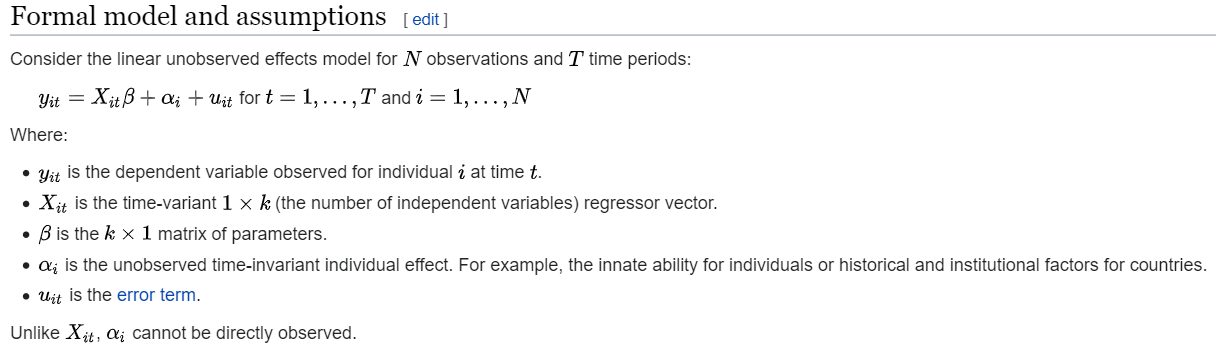

In [300]:
dataset_stdev.index=dataset_stdev.index.reorder_levels([1,0])
dataset_stdev

,varDESC,"gdp,r&d",hi-tech.emloy,household.bb,household.internet,ind.freq.use.,ind.never.used,ind.ordered.online,uni.or.hi-tech,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni,digitalization_indicator_stdev,country
geo,TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,,
AT11,2010,NaN,-0.376867,0.285142,0.361809,0.027433,-0.189248,0.342996,-0.285304,-0.734286,NaN,NaN,NaN,-0.664508,NaN,0.998365,NaN,NaN,-0.998365,-1.284271,NaN,0.023709,AT
AT12,2010,NaN,0.099613,0.228612,0.421022,0.361538,-0.520068,0.477815,0.063625,0.137827,NaN,NaN,NaN,0.183727,NaN,0.998365,NaN,NaN,-0.998365,NaN,NaN,0.161737,AT
AT13,2010,NaN,1.899648,0.567789,0.480235,0.584276,-0.453904,0.567694,0.827495,0.839355,NaN,NaN,NaN,0.214524,NaN,0.998365,NaN,NaN,-0.998365,NaN,NaN,0.639033,AT
AT21,2010,NaN,0.152555,-0.054036,0.184170,0.027433,-0.189248,0.118297,-0.436191,-0.516548,NaN,NaN,NaN,-0.518108,NaN,0.998365,NaN,NaN,-0.998365,NaN,NaN,-0.028146,AT
AT22,2010,NaN,-0.006272,0.285142,0.421022,0.305854,-0.387740,0.387936,-0.304165,-0.054047,NaN,NaN,NaN,-0.139285,NaN,0.998365,NaN,NaN,-0.998365,NaN,NaN,0.100254,AT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,2019,NaN,-0.320167,NaN,NaN,NaN,NaN,NaN,0.798353,NaN,NaN,NaN,NaN,NaN,NaN,-0.436657,NaN,NaN,0.803862,NaN,NaN,0.239093,UK
UKM7,2019,NaN,0.133971,NaN,NaN,NaN,NaN,NaN,1.533778,NaN,-0.223768,NaN,NaN,NaN,NaN,-0.436657,NaN,NaN,-0.168824,NaN,NaN,0.833874,UK
UKM8,2019,NaN,0.133971,NaN,NaN,NaN,NaN,NaN,1.446227,NaN,NaN,NaN,NaN,NaN,NaN,-0.436657,NaN,NaN,-0.585689,NaN,NaN,0.790099,UK


In [301]:
dataset_stdev.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3086 entries, ('AT11', 2010) to ('UKN0', 2019)
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gdp,r&d                         1924 non-null   float64
 1   hi-tech.emloy                   2901 non-null   float64
 2   household.bb                    1558 non-null   float64
 3   household.internet              1566 non-null   float64
 4   ind.freq.use.                   1566 non-null   float64
 5   ind.never.used                  1033 non-null   float64
 6   ind.ordered.online              1566 non-null   float64
 7   uni.or.hi-tech                  3072 non-null   float64
 8   GDP                             2566 non-null   float64
 9   LT-unemp                        526 non-null    float64
 10  at-risk-pov                     75 non-null     float64
 11  highschool                      53 non-null     float64
 12  household.i

In [302]:
indep_vars_list

['GDP',
 'LT-unemp',
 'at-risk-pov',
 'highschool',
 'household.income',
 'low-work-intensity',
 'median.age',
 'populationn.densitty',
 'pov-soc-exclusion',
 'senior_pop',
 'unemp',
 'uni']

In [306]:
["digitalization_indicator_stdev"]+indep_vars_list
dep_vars_list=["digitalization_indicator_stdev"]+dep_vars_list
dep_vars_list

['digitalization_indicator_stdev',
 'digitalization_indicator_norm',
 'digitalization_indicator_norm',
 'digitalization_indicator_norm',
 'gdp,r&d',
 'hi-tech.emloy',
 'household.bb',
 'household.internet',
 'ind.freq.use.',
 'ind.never.used',
 'ind.ordered.online',
 'uni.or.hi-tech']

In [307]:
dataset_stdev[dep_vars_list[0]].index.get_level_values(1).nunique()
dataset_stdev.loc[:,indep_vars_list].index.get_level_values(1).nunique()

10

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html

In [276]:
from linearmodels import PanelOLS

In [308]:
#INPUTS
Y=dataset_stdev[dep_vars_list[0]].fillna(0)
X=dataset_stdev.loc[:,indep_vars_list].fillna(0)

In [310]:
# import statsmodels.api as sm
mod = PanelOLS(Y, #X
               X, #Y
               entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_stdev,R-squared:,0.0443
Estimator:,PanelOLS,R-squared (Between):,-0.0645
No. Observations:,3086,R-squared (Within):,0.0443
Date:,"Wed, Apr 13 2022",R-squared (Overall):,-0.0816
Time:,00:37:32,Log-likelihood,849.81
Cov. Estimator:,Clustered,,
,,F-statistic:,10.612
Entities:,326,P-value,0.0000
Avg Obs:,9.4663,Distribution:,"F(12,2748)"
Min Obs:,2.0000,,
Max Obs:,10.0000,F-statistic (robust):,9.7946


In [311]:
np.array(res.summary)

array(<class 'linearmodels.compat.statsmodels.Summary'>
"""
                                PanelOLS Estimation Summary                                 
Dep. Variable:     digitalization_indicator_stdev   R-squared:                        0.0443
Estimator:                               PanelOLS   R-squared (Between):             -0.0645
No. Observations:                            3086   R-squared (Within):               0.0443
Date:                            Wed, Apr 13 2022   R-squared (Overall):             -0.0816
Time:                                    00:37:32   Log-likelihood                    849.81
Cov. Estimator:                         Clustered                                           
                                                    F-statistic:                      10.612
Entities:                                     326   P-value                           0.0000
Avg Obs:                                   9.4663   Distribution:                 F(12,2748)
Min Obs:  

In [312]:
# import statsmodels.api as sm
mod = PanelOLS(Y,
               X,
               entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_stdev,R-squared:,0.0436
Estimator:,PanelOLS,R-squared (Between):,-0.0647
No. Observations:,3086,R-squared (Within):,0.0396
Date:,"Wed, Apr 13 2022",R-squared (Overall):,-0.0798
Time:,00:37:39,Log-likelihood,883.22
Cov. Estimator:,Clustered,,
,,F-statistic:,10.395
Entities:,326,P-value,0.0000
Avg Obs:,9.4663,Distribution:,"F(12,2739)"
Min Obs:,2.0000,,
Max Obs:,10.0000,F-statistic (robust):,7.7170


### ROBUSTNESS TEST

In the robusteness tests only entity effects of the baseline models are included.
The dimensions of the study along which the robustness tests are conducted are:

    1. time dimension:
        1. model with time-series average of the X and Y -> cross-sectional regression
        2. split the sample in half: before and after 2005
        
    2. entity
        1. countries Panel Data regression
        2. randomly sample half of the entities
        3. rich countries and poor regions (above and below median)
        

#### ROBUSTNESS TEST 1.1 (TIME-SERIES AVERAGE)

In [281]:
import statsmodels.api as sm

In [313]:
Y.groupby(level=0).mean()

geo
AT11    0.022289
AT12    0.221135
AT13    0.804950
AT21    0.145350
AT22    0.287813
          ...   
UKM6   -0.121026
UKM7    0.926012
UKM8    0.628134
UKM9   -0.119183
UKN0    0.110791
Name: digitalization_indicator_stdev, Length: 326, dtype: float64

In [314]:
X.groupby(level=0).mean()

varDESC,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni
geo,,,,,,,,,,,,
AT11,-0.690669,0.000000,-0.290001,0.0,-0.673780,-0.456718,0.723021,-0.152183,-0.436249,-0.365348,-0.209432,-0.024885
AT12,0.132003,0.000000,-0.498361,0.0,0.223554,-0.263810,0.723021,-0.147870,-0.610455,-0.505670,0.000000,0.007328
AT13,0.750868,0.000000,0.832114,0.0,0.244573,1.113570,0.723021,1.956092,0.766246,-0.816955,0.000000,0.102071
AT21,-0.493801,-0.078117,-0.204930,0.0,-0.525112,0.229823,0.723021,-0.160668,-0.243884,-0.377032,0.000000,0.004486
AT22,-0.044587,-0.169765,-0.025525,0.0,-0.113799,0.116524,0.723021,-0.153281,-0.157143,-0.494030,0.000000,-0.024885
...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,0.000000,-0.133208,0.000000,0.0,0.000000,0.000000,0.669360,-0.180009,0.000000,-0.090003,-0.741528,0.422876
UKM7,0.000000,-0.186918,0.000000,0.0,0.000000,0.000000,0.559695,-0.164225,0.000000,-0.419323,0.000000,0.351710
UKM8,0.000000,-0.075565,0.000000,0.0,0.000000,0.000000,0.559695,0.190456,0.000000,-0.680721,0.000000,0.269599


In [315]:
mod = sm.OLS(Y.groupby(level=0).mean(),
             X.groupby(level=0).mean())
res = mod.fit()
print(res.summary())

                                       OLS Regression Results                                      
Dep. Variable:     digitalization_indicator_stdev   R-squared (uncentered):                   0.394
Model:                                        OLS   Adj. R-squared (uncentered):              0.371
Method:                             Least Squares   F-statistic:                              17.00
Date:                            Wed, 13 Apr 2022   Prob (F-statistic):                    6.50e-28
Time:                                    00:37:49   Log-Likelihood:                         -397.63
No. Observations:                             326   AIC:                                      819.3
Df Residuals:                                 314   BIC:                                      864.7
Df Model:                                      12                                                  
Covariance Type:                        nonrobust                                                  


#### ROBUSTNESS TEST 1.2 (SPLIT THE SAMPLE ALONG T IN HALF)

**BEFORE 2015 (INCLUDED)**

In [316]:
X[X.index.get_level_values(1)<=2015]

,varDESC,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni
geo,TIME_PERIOD,,,,,,,,,,,,
AT11,2010,-0.734286,0.0,0.0,0.0,-0.664508,0.0,0.998365,0.000000,0.0,-0.998365,-1.284271,0.0
AT12,2010,0.137827,0.0,0.0,0.0,0.183727,0.0,0.998365,0.000000,0.0,-0.998365,0.000000,0.0
AT13,2010,0.839355,0.0,0.0,0.0,0.214524,0.0,0.998365,0.000000,0.0,-0.998365,0.000000,0.0
AT21,2010,-0.516548,0.0,0.0,0.0,-0.518108,0.0,0.998365,0.000000,0.0,-0.998365,0.000000,0.0
AT22,2010,-0.054047,0.0,0.0,0.0,-0.139285,0.0,0.998365,0.000000,0.0,-0.998365,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,2015,0.000000,0.0,0.0,0.0,0.000000,0.0,0.998441,-0.360278,0.0,-0.998441,-0.794845,0.0
UKM7,2015,0.000000,0.0,0.0,0.0,0.000000,0.0,0.998441,-0.247057,0.0,-0.998441,0.000000,0.0
UKM8,2015,0.000000,0.0,0.0,0.0,0.000000,0.0,0.998441,0.283805,0.0,-0.998441,0.000000,0.0


In [317]:
Y[Y.index.get_level_values(1)<=2015]

geo   TIME_PERIOD
AT11  2010           0.023709
AT12  2010           0.161737
AT13  2010           0.639033
AT21  2010          -0.028146
AT22  2010           0.100254
                       ...   
UKM6  2015          -0.305561
UKM7  2015           0.795272
UKM8  2015           0.476221
UKM9  2015          -0.308149
UKN0  2015           0.030773
Name: digitalization_indicator_stdev, Length: 1804, dtype: float64

In [318]:
mod = sm.OLS(Y[Y.index.get_level_values(1)<=2015],
             X[X.index.get_level_values(1)<=2015])
res = mod.fit()
print(res.summary())

                                       OLS Regression Results                                      
Dep. Variable:     digitalization_indicator_stdev   R-squared (uncentered):                   0.207
Model:                                        OLS   Adj. R-squared (uncentered):              0.202
Method:                             Least Squares   F-statistic:                              42.48
Date:                            Wed, 13 Apr 2022   Prob (F-statistic):                    2.12e-82
Time:                                    00:37:57   Log-Likelihood:                         -2314.1
No. Observations:                            1804   AIC:                                      4650.
Df Residuals:                                1793   BIC:                                      4711.
Df Model:                                      11                                                  
Covariance Type:                        nonrobust                                                  


**AFTER 2015 (INCLUDED)**

In [319]:
X[X.index.get_level_values(1)>2015]

,varDESC,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni
geo,TIME_PERIOD,,,,,,,,,,,,
AT11,2016,-0.648488,0.000000,-0.515972,0.0,-0.672477,-1.485537,0.998436,-0.305015,-0.751372,0.589564,0.0,0.0
AT12,2016,0.085063,0.000000,-1.009404,0.0,0.243334,-1.101976,0.998436,-0.298152,-1.016423,0.304937,0.0,0.0
AT13,2016,0.650097,0.000000,0.734057,0.0,0.259597,1.254183,0.998436,3.509861,0.624369,-0.406632,0.0,0.0
AT21,2016,-0.481608,-0.164036,-0.795583,0.0,-0.524362,0.048706,0.998436,-0.321137,-0.599915,0.565845,0.0,0.0
AT22,2016,-0.070722,0.000000,-0.219912,0.0,-0.107779,-0.197869,0.998436,-0.307826,-0.334864,0.304937,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,2019,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.436657,0.000000,0.000000,0.803862,0.0,0.0
UKM7,2019,0.000000,-0.223768,0.000000,0.0,0.000000,0.000000,-0.436657,0.000000,0.000000,-0.168824,0.0,0.0
UKM8,2019,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.436657,0.000000,0.000000,-0.585689,0.0,0.0


In [320]:
Y[Y.index.get_level_values(1)>2015]

geo   TIME_PERIOD
AT11  2016           0.061325
AT12  2016           0.316971
AT13  2016           0.873155
AT21  2016           0.159870
AT22  2016           0.092614
                       ...   
UKM6  2019           0.239093
UKM7  2019           0.833874
UKM8  2019           0.790099
UKM9  2019           0.213928
UKN0  2019           0.355904
Name: digitalization_indicator_stdev, Length: 1282, dtype: float64

In [321]:
mod = sm.OLS(Y[Y.index.get_level_values(1)>2015],
             X[X.index.get_level_values(1)>2015])
res = mod.fit()
print(res.summary())

                                       OLS Regression Results                                      
Dep. Variable:     digitalization_indicator_stdev   R-squared (uncentered):                   0.280
Model:                                        OLS   Adj. R-squared (uncentered):              0.273
Method:                             Least Squares   F-statistic:                              41.14
Date:                            Wed, 13 Apr 2022   Prob (F-statistic):                    4.31e-82
Time:                                    00:38:06   Log-Likelihood:                         -1459.9
No. Observations:                            1282   AIC:                                      2944.
Df Residuals:                                1270   BIC:                                      3006.
Df Model:                                      12                                                  
Covariance Type:                        nonrobust                                                  


#### ROBUSTNESS TEST 2.1 (COUNTRY TEST)

In [322]:
X_country=X.copy()
X_country.loc[:,"country"]=X_country.index.get_level_values(0).str[:2]
X_country=X_country.droplevel(0).reset_index().set_index(["country","TIME_PERIOD"]).groupby(level=[0,1]).mean()
X_country

varDESC                   GDP  LT-unemp  at-risk-pov  highschool  \
country TIME_PERIOD                                                
AT      2010        -0.157877  0.000000     0.000000         0.0   
        2011        -0.213564 -0.102174     0.000000         0.0   
        2012        -0.140460 -0.257926     0.000000         0.0   
        2013        -0.195147 -0.137032     0.000000         0.0   
        2014        -0.115433 -0.041047    -0.121508         0.0   
...                       ...       ...          ...         ...   
UK      2015         0.000000 -0.075406     0.000000         0.0   
        2016         0.000000 -0.290350     0.000000         0.0   
        2017         0.000000 -0.191643     0.000000         0.0   
        2018         0.000000 -0.073193     0.000000         0.0   
        2019         0.000000 -0.111494     0.000000         0.0   

varDESC              household.income  low-work-intensity  median.age  \
country TIME_PERIOD                                                     
AT      2010                -0.265828            0.000000    0.998365   
        2011                -0.315399            0.000000    0.998348   
        2012                -0.241608            0.000000    0.998160   
        2013                -0.291933            0.000000    0.998219   
        2014                -0.230206            0.471439    0.998441   
...                               ...                 ...         ...   
UK      2015                 0.000000            0.000000    0.998441   
        2016                 0.000000            0.000000    0.998436   
        2017                 0.000000            0.000000    0.998436   
        2018                 0.000000            0.000000   -0.198928   
        2019                 0.000000            0.000000   -0.436657   

varDESC              populationn.densitty  pov-soc-exclusion  senior_pop  \
country TIME_PERIOD                                                        
AT      2010                     0.000000           0.000000   -0.998365   
        2011                     0.000000           0.000000   -0.998348   
        2012                     0.000000           0.000000   -0.998160   
        2013                     0.000000           0.000000   -0.998219   
        2014                     0.000000          -0.516002   -0.998441   
...                                   ...                ...         ...   
UK      2015                     0.690327           0.000000   -0.998441   
        2016                     0.694836           0.000000    0.030723   
        2017                     0.703523           0.000000   -0.000068   
        2018                     0.704491           0.000000   -0.026202   
        2019                     0.000000           0.000000   -0.048509   

varDESC                 unemp       uni  
country TIME_PERIOD                      
AT      2010        -0.142697  0.000000  
        2011        -0.095267  0.000000  
        2012         0.000000  0.000000  
        2013         0.000000  0.000000  
        2014         0.000000  0.026959  
...                       ...       ...  
UK      2015        -0.036458  0.000000  
        2016        -0.075505  0.000000  
        2017        -0.077217  0.000000  
        2018        -0.101805  0.000000  
        2019        -0.046918  0.000000  

[337 rows x 12 columns]

In [323]:
Y_country=Y.copy().to_frame()
Y_country.loc[:,"country"]=Y_country.index.get_level_values(0).str[:2]
Y_country=Y_country.droplevel(0).reset_index().set_index(["country","TIME_PERIOD"]).groupby(level=[0,1]).mean()
Y_country

digitalization_indicator_stdev
country TIME_PERIOD                                
AT      2010                               0.140962
        2011                               0.080163
        2012                               0.215365
        2013                               0.175529
        2014                               0.154323
...                                             ...
UK      2015                               0.428867
        2016                               0.542181
        2017                               0.441203
        2018                               0.577531
        2019                               0.698048

[337 rows x 1 columns]

In [324]:
# import statsmodels.api as sm
mod = PanelOLS(Y_country, #X
               X_country, #Y
               entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_stdev,R-squared:,0.2209
Estimator:,PanelOLS,R-squared (Between):,-0.7092
No. Observations:,337,R-squared (Within):,0.2209
Date:,"Wed, Apr 13 2022",R-squared (Overall):,-0.6549
Time:,00:38:46,Log-likelihood,177.55
Cov. Estimator:,Clustered,,
,,F-statistic:,6.8522
Entities:,35,P-value,0.0000
Avg Obs:,9.6286,Distribution:,"F(12,290)"
Min Obs:,6.0000,,
Max Obs:,10.0000,F-statistic (robust):,19.287


In [325]:
# import statsmodels.api as sm
mod = PanelOLS(Y_country,
               X_country,
               entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_stdev,R-squared:,0.1987
Estimator:,PanelOLS,R-squared (Between):,-0.6324
No. Observations:,337,R-squared (Within):,0.2076
Date:,"Wed, Apr 13 2022",R-squared (Overall):,-0.5803
Time:,00:38:54,Log-likelihood,184.28
Cov. Estimator:,Clustered,,
,,F-statistic:,5.8053
Entities:,35,P-value,0.0000
Avg Obs:,9.6286,Distribution:,"F(12,281)"
Min Obs:,6.0000,,
Max Obs:,10.0000,F-statistic (robust):,87.431


#### ROBUSTNESS TEST 2.2 (RANDOM SELECTION OF ENTITIES)

In [326]:
XY=pd.merge(X, Y, left_index=True, right_index=True, how="inner")
XY

,,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni,digitalization_indicator_stdev
geo,TIME_PERIOD,,,,,,,,,,,,,
AT11,2010,-0.734286,0.000000,0.0,0.0,-0.664508,0.0,0.998365,0.0,0.0,-0.998365,-1.284271,0.0,0.023709
AT12,2010,0.137827,0.000000,0.0,0.0,0.183727,0.0,0.998365,0.0,0.0,-0.998365,0.000000,0.0,0.161737
AT13,2010,0.839355,0.000000,0.0,0.0,0.214524,0.0,0.998365,0.0,0.0,-0.998365,0.000000,0.0,0.639033
AT21,2010,-0.516548,0.000000,0.0,0.0,-0.518108,0.0,0.998365,0.0,0.0,-0.998365,0.000000,0.0,-0.028146
AT22,2010,-0.054047,0.000000,0.0,0.0,-0.139285,0.0,0.998365,0.0,0.0,-0.998365,0.000000,0.0,0.100254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,2019,0.000000,0.000000,0.0,0.0,0.000000,0.0,-0.436657,0.0,0.0,0.803862,0.000000,0.0,0.239093
UKM7,2019,0.000000,-0.223768,0.0,0.0,0.000000,0.0,-0.436657,0.0,0.0,-0.168824,0.000000,0.0,0.833874
UKM8,2019,0.000000,0.000000,0.0,0.0,0.000000,0.0,-0.436657,0.0,0.0,-0.585689,0.000000,0.0,0.790099


In [328]:
XY=XY.iloc[list(np.random.randint(0, high=XY.shape[0], size=1535, dtype=int)),:]
XY["digitalization_indicator_stdev"]
XY.loc[:,XY.columns[:-1]]

,,GDP,LT-unemp,at-risk-pov,highschool,household.income,low-work-intensity,median.age,populationn.densitty,pov-soc-exclusion,senior_pop,unemp,uni
geo,TIME_PERIOD,,,,,,,,,,,,
BE35,2017,-0.585059,0.799331,0.000000,0.000000,-0.577812,0.000000,0.998436,-0.258053,0.000000,-0.220165,0.470863,0.000000
FRF1,2014,0.000000,0.000000,0.000000,0.000000,0.225272,0.000000,0.998441,0.000000,0.000000,-0.998441,0.000000,0.205919
PL84,2016,-0.632110,1.176374,0.000000,0.000000,-0.685935,0.000000,0.998436,-0.322791,0.000000,-0.477789,0.300506,-0.151494
DE11,2010,2.648919,-0.590789,0.000000,0.000000,1.979132,0.000000,0.998365,0.000000,0.000000,-0.998365,-0.929067,0.318456
BG33,2016,-0.698027,0.000000,1.507100,0.000000,-0.779141,0.870622,0.998436,-0.317169,2.908856,0.186342,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ITC4,2010,6.818918,0.000000,0.000000,0.000000,5.512935,0.000000,0.998365,0.000000,0.000000,-0.998365,0.000000,0.000000
RO32,2013,-0.063536,0.000000,0.000000,2.304546,-0.329433,0.000000,0.998219,0.000000,0.000000,-0.998219,0.000000,0.000000
DK01,2011,1.122975,0.000000,0.263752,0.000000,0.462476,0.000000,0.998348,0.000000,0.307916,-0.998348,0.000000,0.000000


In [329]:
# import statsmodels.api as sm
mod = PanelOLS(XY["digitalization_indicator_stdev"], #X
               XY.loc[:,XY.columns[:-1]], #Y
               entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_stdev,R-squared:,0.0681
Estimator:,PanelOLS,R-squared (Between):,-0.4132
No. Observations:,1535,R-squared (Within):,0.0681
Date:,"Wed, Apr 13 2022",R-squared (Overall):,-0.3848
Time:,00:39:27,Log-likelihood,786.65
Cov. Estimator:,Clustered,,
,,F-statistic:,7.4063
Entities:,326,P-value,0.0000
Avg Obs:,4.7086,Distribution:,"F(12,1217)"
Min Obs:,0.0000,,
Max Obs:,16.000,F-statistic (robust):,3.5148


In [330]:
# import statsmodels.api as sm
mod = PanelOLS(XY["digitalization_indicator_stdev"], 
               XY.loc[:,XY.columns[:-1]], 
               entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

Dep. Variable:,digitalization_indicator_stdev,R-squared:,0.0722
Estimator:,PanelOLS,R-squared (Between):,-0.4596
No. Observations:,1535,R-squared (Within):,0.0639
Date:,"Wed, Apr 13 2022",R-squared (Overall):,-0.4265
Time:,00:39:36,Log-likelihood,828.85
Cov. Estimator:,Clustered,,
,,F-statistic:,7.8329
Entities:,326,P-value,0.0000
Avg Obs:,4.7086,Distribution:,"F(12,1208)"
Min Obs:,0.0000,,
Max Obs:,16.000,F-statistic (robust):,2.5277


#### ROBUSTNESS TEST 2.3 (RICH AND POOR REGIONS)

# VISUALIZATION

In [ ]:
# read the NUTS shapefile and extract the polygons for a individual countries
# nuts=gpd.read_file("./data/NUTS_RG_10M_2021_4326.shp")
nuts=gpd.read_file("./data/NUTS_RG_10M_2016_4326.shp")
nuts["id"]=nuts["NUTS_ID"]
nuts=nuts.loc[:,["id","CNTR_CODE","NUTS_NAME","LEVL_CODE","FID","NUTS_ID","geometry"]]
df_geo=nuts.copy()
df_geo

In [ ]:
df_geo=df_geo[df_geo["LEVL_CODE"]==2]
# df_geo["id"].str.len().max()
# df_geo["id"].str.len().min()
df_geo

In [ ]:
df_merged = df_geo.merge(dataset_norm.reset_index(), left_on='NUTS_ID', right_on='geo', how="right")
df_merged

Missing data

In [ ]:
df_merged[df_merged["NUTS_ID"].isna()]["geo"].unique()

In [ ]:
#missing records
df_merged[df_merged["NUTS_ID"].isna()]

In [ ]:
df_merged=df_merged[~df_merged["NUTS_ID"].isna()]

## SINGLE COUNTRY

In [ ]:
time = 2016
hue_selection = [
    f'{row.dataset}_{time}_{row.meta_idx}'
    for row in df_meta.groupby('dataset').apply(lambda x: x.sample(n=1)).itertuples()
]
hue_selection

In [ ]:
size = int(np.ceil(np.sqrt(len(hue_selection))))  # size of plot grid

fig, axes = plt.subplots(nrows=size, ncols=size, figsize=(20, 20))
[ax.axis('off') for ax in axes.ravel()]

for hue, ax in zip(hue_selection, axes.ravel()):
    sub = df_merged[(df_merged['CNTR_CODE'] == 'DE')]

    gplt.choropleth(sub, hue=hue, legend=True, ax=ax)
    ax.set_aspect(1.4)
    ax.set_title(get_meta(hue), fontsize=10)

## EUROPE

In [ ]:
df_merged.set_index("CNTR_CODE", inplace=True)
# df_merged=df_merged.fillna(0) #maybe avoid 
df_merged

The following loop iterate over all the years and all the variables and save all the plots in the "figures" folder

In [ ]:
for year in list(df_merged.loc[:,"TIME_PERIOD"].unique()):
    for variable in dep_vars_list+indep_vars_list:

        ax = gplt.choropleth(
            df_merged[df_merged.loc[:,"TIME_PERIOD"]==year],
            hue=variable,
            legend=True,  # k=5,
            figsize=(16, 12),
            extent=(
                -25,
                30,
                45,
                75,
            ),  # (min_longitude, min_latitude, max_longitude, max_latitude)
        )
        ax.set_aspect(1.4)
        ax.set_title(variable+" "+str(year))
        ax.figure.savefig('./figures/{} - {}.png'.format(variable,str(year)))

Manual plot: you can choose the year and the variable to plot

In [ ]:
year=2019
variable="population.density"

In [ ]:
ax = gplt.choropleth(
    df_merged[df_merged.loc[:,"TIME_PERIOD"]==year],
    hue=variable,
    legend=True,  # k=5,
    figsize=(16, 12),
    extent=(
        -25,
        30,
        45,
        75,
    ),  # (min_longitude, min_latitude, max_longitude, max_latitude)
)
ax.set_aspect(1.4)
ax.set_title(variable+" "+str(year))
ax.figure.savefig('./figures/{} - {}.png'.format(variable,str(year)))